# The Smart Local Analysis
Author: Sebastian Png and Clara Biedermann

# Import Libraries

In [1]:
import copy
import math
import os
import re
import sys
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm

from scipy import stats
from sklearn.ensemble import (AdaBoostClassifier, GradientBoostingClassifier,
                              RandomForestClassifier, RandomForestRegressor,
                              StackingClassifier, VotingClassifier)
from sklearn.feature_selection import RFE
from sklearn.inspection import permutation_importance
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import (accuracy_score, classification_report, 
                             confusion_matrix, mean_absolute_error,
                             mean_squared_error)
from sklearn.model_selection import (cross_val_score, GridSearchCV,
                                     RandomizedSearchCV, RepeatedStratifiedKFold,
                                     train_test_split)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from statistics import mode
from typing import List, Tuple
from xgboost import XGBRegressor

In [2]:
warnings.filterwarnings('ignore')

# Utility Functions

In [3]:
def display_df(df: pd.DataFrame, n: int = 5) -> None:
    """Displays truncated DataFrame along with its shape."""
    print(f'Number of rows: {df.shape[0]}\nNumber of columns: {df.shape[1]}')
    display(df.head(n=n))
    
def get_year_month(df: pd.DataFrame) -> List[str]:
    """Returns a list of dates in the format of yyyy-mm."""
    months = sorted(df['publish_date'].apply(lambda x: x.strftime('%Y-%m'))
                                      .unique().tolist())
    return months

def plot_boxplot(df: pd.DataFrame, col: str, title: str) -> None:
    """Plot a boxplot from a dataframe column."""
    plt.figure(figsize=(10,3))
    plt.title(title, fontsize=20, fontweight='bold')
    sns.set_theme(style='whitegrid')
    sns.boxplot(x=df[col])
    plt.show()
    
def plot_confusion_matrix(model, X, y_true, y_pred):
    """Plots a Confusion Matrix."""
    cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
    TP = cm[1, 1]
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    
    accuracy = (TP + TN) / (TP + TN + FP + FN)
    precision = TP / (TP + FP)
    recall = TP / (TP + FN)
    f1 = 2*(recall * precision) / (recall + precision)
    
    y_pred_prob = model.predict_proba(X=X)[:, 1]
    roc_auc = roc_auc_score(y_true=y_true, y_score=y_pred_prob)
    
    print(f'Accuracy: {accuracy}\nPrecision: {precision}')
    print(f'Recall: {recall}\nROC_AUC: {roc_auc}\nF1 Score: {f1}')
    print('Confusion Matrix:\n', cm)

def plot_feature_impt(model, X) -> pd.DataFrame:
    """Plots a bar chart of descending feature importances of a model."""
    if hasattr(model, 'feature_importances_'): 
        feature_importance = model.feature_importances_
    elif hasattr(model, 'coef_'):
        feature_importance = abs(model.coef_)
    feature_impt = (pd.DataFrame({'Features': X.columns,
                                  'Importance': feature_importance})
                    .sort_values(by = 'Importance', ascending=False))

    plt.figure(figsize=(8,8))
    sns.barplot(x='Importance', y='Features', data=feature_impt)
    plt.show()
    
    return feature_impt

def plot_roc(model, X, y_true, y_pred):
    """Plot a roc curve from a model."""
    y_pred_prob = model.predict_proba(X=X)[:, 1]
    roc_auc = roc_auc_score(y_true=y_true, y_score=y_pred_prob)
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
    
    plt.figure()
    plt.plot(fpr, tpr, label='Multinomial Naive Bayes (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1],'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()
    
def plot_scatter(df: pd.DataFrame, x: str, y: str, title: str = '',
                 x_label: str = '', y_label: str = '', x_rotation: str = 0,
                 figsize: Tuple[float, float] = (15, 8),
                 xticks: List[str] = None, x_vert: int = None) -> None:
    """Plots a scatterplot between 2 dataframe columns."""
    with sns.plotting_context('notebook', font_scale=1.2):
        plt.figure(figsize=figsize)
        ax = sns.scatterplot(data=df, x=x, y=y)
        ax.set(xticks=xticks)
        ax.set(title=title, xlabel=x_label, ylabel=y_label)
        plt.xticks(rotation=x_rotation)
        
        if x_vert:
            plt.axvline(x=plt.xticks()[0][x_vert], color='red')
        
        plt.show()
        
def cyclical_transform(df: pd.DataFrame, columns: List[str],
                       drop: bool = False) -> pd.DataFrame:
    """Returns a new DataFrame with cyclical transformed columns."""
    df_new = df.copy()
    for col in columns:
        s = df[col]
        max_value = s.max()
        sin_values = [math.sin((2 * math.pi * x)/max_value) for x in list(s)]
        cos_values = [math.cos((2 * math.pi * x)/max_value) for x in list(s)]
        df_new[col + "_sin"], df_new[col + "_cos"] = sin_values, cos_values
    
    return df_new

# Import Dataset

In [4]:
df = pd.read_parquet(path='./datasets/thesmartlocalfinal.parquet',
                     engine='pyarrow')

display_df(df=df, n=3)

Number of rows: 4080
Number of columns: 37


,url,timedelta,title,category,subcategory1,subcategory2,subcategory3,preview,content,n_tokens_title,...,img_links,num_hrefs,num_self_hrefs,num_tags,num_shares,img_dark,img_light,img_saturation,top3_colours,bot3_colours
0,https://thesmartlocal.com/read/staytion-marsil...,0,Staytion Marsiling: Coworking Space In The Nor...,Adulting,Career,None,None,"Hooray for being able to sleep in, plus the ti...",Staytion Marsiling – Coworking space in the No...,15,...,[https://thesmartlocal.com/wp-content/uploads/...,17,17,1,27,"[0.81, 0.65, 0.72, 0.91, 0.74, 0.33, 0.52]","[0.19, 0.35, 0.28, 0.09, 0.26, 0.67, 0.48]","[46.14, 62.21, 69.59, 52.29, 54.78, 50.83, 53.62]","[[black, black, black], [lightslategray, light...","[[gray, gray, gray], [gray, gray, gray], [blac..."
1,https://thesmartlocal.com/read/things-to-do-es...,1,"Esplanade Is Having Free Shows, A Theatre BTS ...",Things To Do,Things To Do In Singapore,None,None,Do not miss the free entertainment here.,Things to do at Esplanade So you’ve been to Es...,17,...,[https://thesmartlocal.com/wp-content/uploads/...,7,7,2,73,"[0.51, 0.93, 0.69, 0.34, 0.91]","[0.49, 0.07, 0.31, 0.66, 0.09]","[85.23, 104.4, 151.83, 69.18, 100.27]","[[darkseagreen, tan, darkgray], [black, darksl...","[[lightsteelblue, darkgray, slategray], [india..."
2,https://thesmartlocal.com/read/things-to-do-no...,1,17 New Things To Do In November 2022 – Bishan ...,Things To Do,Activities,None,None,"In the blink of an eye, we're approaching 2023...",Things to do in November 2022 Halloween may be...,19,...,[https://thesmartlocal.com/wp-content/uploads/...,63,63,6,244,"[0.53, 0.35, 0.59, 0.62, 0.53, 0.74, 0.12, 0.4...","[0.47, 0.65, 0.41, 0.38, 0.47, 0.26, 0.88, 0.5...","[128.23, 132.23, 102.29, 145.1, 92.48, 97.79, ...","[[black, black, black], [cornflowerblue, cornf...","[[purple, lightskyblue, lavender], [mistyrose,..."


In [5]:
# Convert publish_date to datetime format
df.publish_date = pd.to_datetime(arg=df.publish_date)

df.dtypes

url                             object
timedelta                        int64
title                           object
category                        object
subcategory1                    object
subcategory2                    object
subcategory3                    object
preview                         object
content                         object
n_tokens_title                   int64
title_polarity                 float64
title_subjectivity             float64
n_tokens_preview                 int64
preview_polarity               float64
preview_subjectivity           float64
n_tokens_content                 int64
content_polarity               float64
content_subjectivity           float64
prop_non_stop                  float64
prop_unique_non_stop           float64
reading_duration                 int32
author                          object
publish_date            datetime64[ns]
day_of_week                      int64
month                            int64
year                     

# Data Filtering

## Based on Publication Date

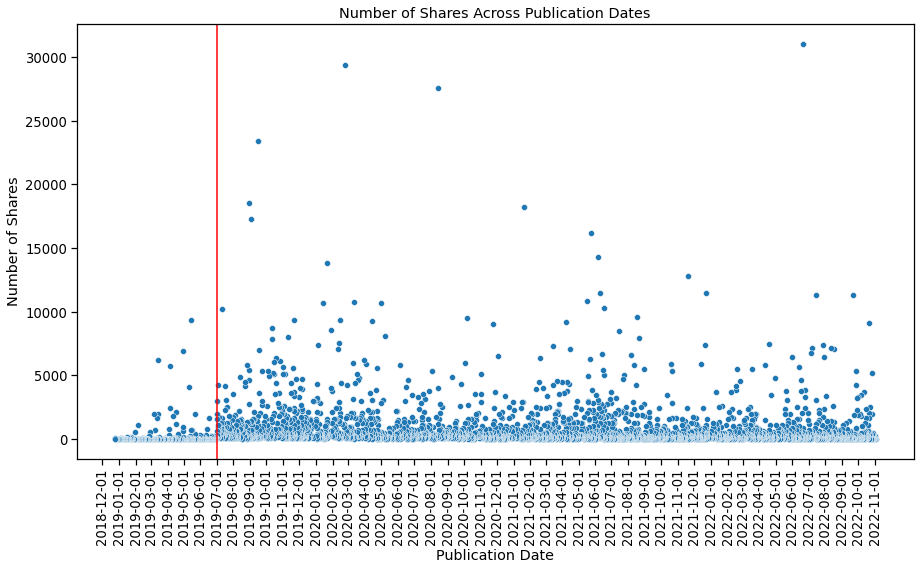

In [6]:
# Plot number of shares across publication dates
plot_scatter(df=df, x='publish_date', y='num_shares',
             title='Number of Shares Across Publication Dates',
             x_label='Publication Date', y_label='Number of Shares',
             x_rotation=90, xticks=get_year_month(df), x_vert=7)

In [7]:
print(f'Latest publish date: {df.publish_date.max()}')

Latest publish date: 2022-11-02 00:00:00


On closer look, it can be seen that the number of article shares start to pick up from July 2019 onwards, which might be attributed to The Smart Local starting to gain more viewers. Hence, we will drop the data before July 2019. Additionally, we drop date since September in order to provide enough timedelta for the articles to gain sufficient sharebility for fair comparison.

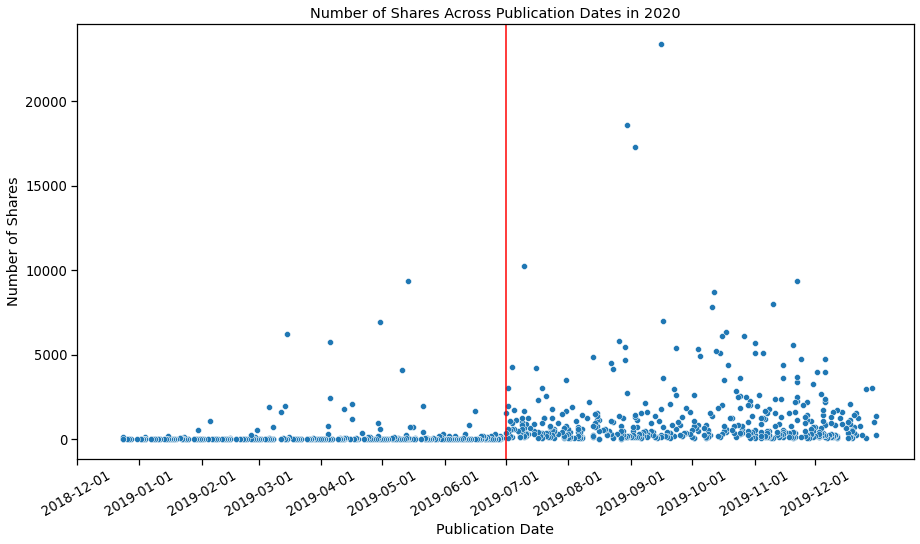

In [8]:
df_2020 = df.query("year < 2020").copy()

# Plot number of shares across publication dates
plot_scatter(df=df_2020, x='publish_date', y='num_shares',
             title='Number of Shares Across Publication Dates in 2020',
             x_label='Publication Date', y_label='Number of Shares',
             x_rotation=30, xticks=get_year_month(df_2020), x_vert=7)

In [9]:
filter_cond = "publish_date >= '2019-07-01' & publish_date < '2022-10-01'"
df_filtered = df.query(filter_cond).copy().reset_index(drop=True)

display_df(df=df_filtered, n=3)

Number of rows: 3515
Number of columns: 37


,url,timedelta,title,category,subcategory1,subcategory2,subcategory3,preview,content,n_tokens_title,...,img_links,num_hrefs,num_self_hrefs,num_tags,num_shares,img_dark,img_light,img_saturation,top3_colours,bot3_colours
0,https://thesmartlocal.com/read/malay-heritage-...,33,There’s A Former Royal Palace In Kampong Gelam...,Local,Heritage,None,None,It’s closing for restoration works until 2025.,Malay Heritage Centre Undoubtedly of the most ...,17,...,[https://thesmartlocal.com/wp-content/uploads/...,9,9,2,15,"[0.6, 0.46, 0.44, 0.48]","[0.4, 0.54, 0.56, 0.52]","[109.26, 140.86, 93.85, 67.41]","[[white, black, azure], [burlywood, burlywood,...","[[gray, dimgray, lightslategray], [saddlebrown..."
1,https://thesmartlocal.com/read/aquarium-shops-...,33,15 Aquarium Shops In Singapore For One-Of-Kind...,Adulting,Pets,None,None,The best places you need to check out if you'r...,Specialty aquarium shops in Singapore One migh...,11,...,[https://thesmartlocal.com/wp-content/uploads/...,74,74,0,334,"[0.59, 0.82, 0.87, 0.68, 0.07, 0.58, 0.63, 0.6...","[0.41, 0.18, 0.13, 0.32, 0.93, 0.42, 0.37, 0.3...","[65.57, 69.43, 119.07, 56.59, 36.66, 114.54, 1...","[[black, wheat, pink], [black, black, white], ...","[[lightsteelblue, whitesmoke, lavender], [dark..."
2,https://thesmartlocal.com/read/klook-8th-birth...,33,Klook Has 1-For-1 Deals & Up To 50% Off Attrac...,Things To Do,Sales & Promotions,None,None,Enjoy discounts on Disneyland tickets and hot ...,Klook’s 8th birthday deals As we close in on t...,19,...,[https://thesmartlocal.com/wp-content/uploads/...,29,29,3,49,"[0.33, 0.48, 0.79, 0.53, 0.57, 0.71, 0.29, 0.3...","[0.67, 0.52, 0.21, 0.47, 0.43, 0.29, 0.71, 0.6...","[50.18, 83.78, 122.17, 58.65, 92.74, 128.63, 5...","[[whitesmoke, darkgray, darkgray], [lavender, ...","[[darkolivegreen, peru, navajowhite], [darkgre..."


## Filter Out Review Articles

In [10]:
df_filtered.category.value_counts()

Things To Do    1839
Local            877
Adulting         570
Travel           225
Reviews            4
Name: category, dtype: int64

In [11]:
df_filtered = df_filtered.query("category != 'Reviews'").reset_index(drop=True)

## Filter Out Articles with No Images
Row 581 (Wordle article) has no images while the rest of the articles with num_imgs = 0 have videos instead, which we will not be analyzing.

In [12]:
display_df(df=df_filtered.query("num_imgs == 0"))

Number of rows: 12
Number of columns: 37


,url,timedelta,title,category,subcategory1,subcategory2,subcategory3,preview,content,n_tokens_title,...,img_links,num_hrefs,num_self_hrefs,num_tags,num_shares,img_dark,img_light,img_saturation,top3_colours,bot3_colours
204,https://thesmartlocal.com/read/national-day-so...,86,10 Best National Day Songs Over The Years Rank...,Local,Culture,None,None,"In the spirit of our nation's birthday, take a...","Best National Day Songs It’s August, and you k...",18,...,[],27,27,2,994,[],[],[],[],[]
241,https://thesmartlocal.com/read/netflix-horror-...,96,10 Horror Movies and Series On Netflix That Ar...,Local,Supernatural & Mystery,None,None,You don't need to wait for Halloween to binge ...,Netflix Horror movies and series Bingeing on h...,14,...,[],26,26,2,6449,[],[],[],[],[]
581,https://thesmartlocal.com/read/best-wordle-words/,197,"11 Best Starting Words For Wordle, Including S...",Things To Do,Gaming,None,None,Is your starting word Adieu? There might be a ...,Best Wordle starting words If you’re seeing gr...,12,...,[],14,14,2,112,[],[],[],[],[]
1026,https://thesmartlocal.com/read/best-dc-movies-...,331,12 Best DC Movies & Shows If You’re Ready To J...,Local,Misc,None,None,From underrated animated series to lighthearte...,Best DC movies & shows “ Eternals is a disaste...,19,...,[],19,19,3,32,[],[],[],[],[]
1546,https://thesmartlocal.com/read/youtube-dance-w...,485,13 Easy YouTube Dance Workouts For Cardio That...,Things To Do,Sports & Fitness,None,None,Get up and work towards your fitness goals wit...,Easy YouTube dance workouts Some people get a ...,10,...,[],28,28,3,357,[],[],[],[],[]


In [13]:
df_filtered = df_filtered.query("num_imgs > 0").reset_index(drop=True)
df_filtered.shape

(3499, 37)

## Filter Out Articles with no Image Features
Rows with empty lists or containing '404' are filtered out as there are either no image features or some errors incurred when processing the images.

In [14]:
# Filter out empty lists in image columns
filter_empty_list = lambda x: len(x) > 0
df_filtered = df_filtered[df_filtered.img_dark.apply(filter_empty_list) &
                          df_filtered.img_light.apply(filter_empty_list) &
                          df_filtered.img_saturation.apply(filter_empty_list) &
                          df_filtered.top3_colours.apply(filter_empty_list) &
                          df_filtered.bot3_colours.apply(filter_empty_list)]

# Filter out rows with 404 in list within image columns
filter_img_error = lambda x: '404' not in x
df_filtered = df_filtered[df_filtered.img_dark.apply(filter_img_error) &
                          df_filtered.img_light.apply(filter_img_error) &
                          df_filtered.img_saturation.apply(filter_img_error)]

img_num_cols = ['img_dark', 'img_light', 'img_saturation']

for col in img_num_cols:
    df_filtered[col] = df_filtered[col].apply(lambda l: list(map(float, l)))

df_filtered.reset_index(drop=True, inplace=True)
df_filtered.shape

(3465, 37)

In [15]:
display_df(df=df_filtered, n=3)

Number of rows: 3465
Number of columns: 37


,url,timedelta,title,category,subcategory1,subcategory2,subcategory3,preview,content,n_tokens_title,...,img_links,num_hrefs,num_self_hrefs,num_tags,num_shares,img_dark,img_light,img_saturation,top3_colours,bot3_colours
0,https://thesmartlocal.com/read/malay-heritage-...,33,There’s A Former Royal Palace In Kampong Gelam...,Local,Heritage,None,None,It’s closing for restoration works until 2025.,Malay Heritage Centre Undoubtedly of the most ...,17,...,[https://thesmartlocal.com/wp-content/uploads/...,9,9,2,15,"[0.6, 0.46, 0.44, 0.48]","[0.4, 0.54, 0.56, 0.52]","[109.26, 140.86, 93.85, 67.41]","[[white, black, azure], [burlywood, burlywood,...","[[gray, dimgray, lightslategray], [saddlebrown..."
1,https://thesmartlocal.com/read/aquarium-shops-...,33,15 Aquarium Shops In Singapore For One-Of-Kind...,Adulting,Pets,None,None,The best places you need to check out if you'r...,Specialty aquarium shops in Singapore One migh...,11,...,[https://thesmartlocal.com/wp-content/uploads/...,74,74,0,334,"[0.59, 0.82, 0.87, 0.68, 0.07, 0.58, 0.63, 0.6...","[0.41, 0.18, 0.13, 0.32, 0.93, 0.42, 0.37, 0.3...","[65.57, 69.43, 119.07, 56.59, 36.66, 114.54, 1...","[[black, wheat, pink], [black, black, white], ...","[[lightsteelblue, whitesmoke, lavender], [dark..."
2,https://thesmartlocal.com/read/klook-8th-birth...,33,Klook Has 1-For-1 Deals & Up To 50% Off Attrac...,Things To Do,Sales & Promotions,None,None,Enjoy discounts on Disneyland tickets and hot ...,Klook’s 8th birthday deals As we close in on t...,19,...,[https://thesmartlocal.com/wp-content/uploads/...,29,29,3,49,"[0.33, 0.48, 0.79, 0.53, 0.57, 0.71, 0.29, 0.3...","[0.67, 0.52, 0.21, 0.47, 0.43, 0.29, 0.71, 0.6...","[50.18, 83.78, 122.17, 58.65, 92.74, 128.63, 5...","[[whitesmoke, darkgray, darkgray], [lavender, ...","[[darkolivegreen, peru, navajowhite], [darkgre..."


In [16]:
df_filtered.describe()

,timedelta,n_tokens_title,title_polarity,title_subjectivity,n_tokens_preview,preview_polarity,preview_subjectivity,n_tokens_content,content_polarity,content_subjectivity,...,prop_unique_non_stop,reading_duration,day_of_week,month,year,num_imgs,num_hrefs,num_self_hrefs,num_tags,num_shares
count,3465.000000,3465.000000,3465.000000,3465.000000,3465.000000,3465.000000,3465.000000,3465.000000,3465.000000,3465.000000,...,3465.000000,3465.000000,3465.000000,3465.000000,3465.000000,3465.000000,3465.000000,3465.000000,3465.000000,3465.000000
mean,581.705628,15.951227,0.138863,0.361327,22.215007,0.151932,0.408513,1322.437518,0.158682,0.472503,...,0.344299,6.555556,2.577201,6.748918,2020.725541,12.688023,18.693218,18.693218,3.247042,746.214141
std,344.517197,2.326717,0.288913,0.308842,6.031069,0.270289,0.291750,692.364061,0.066107,0.056198,...,0.044120,3.469829,1.667305,3.310333,1.002017,8.895073,18.241428,18.241428,1.991069,1722.314638
min,33.000000,7.000000,-1.000000,0.000000,2.000000,-1.000000,0.000000,194.000000,-0.119866,0.219111,...,0.232908,1.000000,0.000000,1.000000,2019.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,291.000000,14.000000,0.000000,0.000000,19.000000,0.000000,0.166667,858.000000,0.117773,0.436191,...,0.312377,4.000000,1.000000,4.000000,2020.000000,7.000000,7.000000,7.000000,2.000000,99.000000
50%,544.000000,16.000000,0.000000,0.383333,23.000000,0.100000,0.433333,1238.000000,0.158667,0.473849,...,0.341748,6.000000,3.000000,7.000000,2021.000000,10.000000,14.000000,14.000000,3.000000,238.000000
75%,870.000000,17.000000,0.276515,0.577273,26.000000,0.312121,0.600000,1654.000000,0.201007,0.508988,...,0.374214,8.000000,4.000000,9.000000,2022.000000,16.000000,26.000000,26.000000,4.000000,648.000000
max,1220.000000,24.000000,1.000000,1.000000,35.000000,1.000000,1.000000,14627.000000,0.412500,0.697633,...,0.546332,73.000000,6.000000,12.000000,2022.000000,135.000000,380.000000,380.000000,17.000000,31063.000000


# Feature Engineering

## Count of Articles Written by Author

In [17]:
author_to_count = dict(df_filtered.author.value_counts())

df_filtered.insert(loc=df_filtered.columns.get_loc('url') + 1,
                   column='num_articles_written',
                   value=df_filtered.author.apply(lambda x: author_to_count[x]))

## Image Columns
### Min, Average, Max

In [18]:
name_to_function = {
    'min': lambda x: min(x),
    'avg': lambda x: sum(x)/len(x),
    'max': lambda x: max(x)
}

for col in ['img_dark', 'img_light', 'img_saturation']:
    for k, v in name_to_function.items():
        df_filtered[col + f'_{k}'] = df_filtered[col].apply(v)

display_df(df=df_filtered, n=1)

Number of rows: 3465
Number of columns: 47


,url,num_articles_written,timedelta,title,category,subcategory1,subcategory2,subcategory3,preview,content,...,bot3_colours,img_dark_min,img_dark_avg,img_dark_max,img_light_min,img_light_avg,img_light_max,img_saturation_min,img_saturation_avg,img_saturation_max
0,https://thesmartlocal.com/read/malay-heritage-...,27,33,There’s A Former Royal Palace In Kampong Gelam...,Local,Heritage,None,None,It’s closing for restoration works until 2025.,Malay Heritage Centre Undoubtedly of the most ...,...,"[[gray, dimgray, lightslategray], [saddlebrown...",0.44,0.495,0.6,0.4,0.505,0.56,67.41,102.845,140.86


### Count of Top Colour Across DataFrame

In [19]:
# Flatten nested list and get element with top frequency
get_top_colour = lambda x: mode([y for sl in x for y in sl])
colour_to_count = dict(df_filtered.top3_colours.apply(lambda x: get_top_colour(x))
                                  .value_counts())

df_filtered['top_colour'] = df_filtered.top3_colours \
                                       .apply(lambda x: 
                                              colour_to_count[get_top_colour(x)])

### Feature Crosses

In [20]:
for metric in ['avg', 'max', 'min']:
    df_filtered[f'img_{metric}'] = ((df_filtered[f'img_dark_{metric}'] * 
                                     df_filtered[f'img_light_{metric}'] * 
                                     df_filtered[f'img_saturation_{metric}']) / 
                                    df_filtered['num_imgs'])
display_df(df=df_filtered, n=1)    

Number of rows: 3465
Number of columns: 51


,url,num_articles_written,timedelta,title,category,subcategory1,subcategory2,subcategory3,preview,content,...,img_light_min,img_light_avg,img_light_max,img_saturation_min,img_saturation_avg,img_saturation_max,top_colour,img_avg,img_max,img_min
0,https://thesmartlocal.com/read/malay-heritage-...,27,33,There’s A Former Royal Palace In Kampong Gelam...,Local,Heritage,None,None,It’s closing for restoration works until 2025.,Malay Heritage Centre Undoubtedly of the most ...,...,0.4,0.505,0.56,67.41,102.845,140.86,2,6.42717,11.83224,2.96604


# Data Preprocessing

## Sine-Cosine Transformation of Day of Week and Month

In [21]:
smartlocal = cyclical_transform(df=df_filtered, columns=['day_of_week', 'month'])
display_df(df=smartlocal, n=3)

Number of rows: 3465
Number of columns: 55


,url,num_articles_written,timedelta,title,category,subcategory1,subcategory2,subcategory3,preview,content,...,img_saturation_avg,img_saturation_max,top_colour,img_avg,img_max,img_min,day_of_week_sin,day_of_week_cos,month_sin,month_cos
0,https://thesmartlocal.com/read/malay-heritage-...,27,33,There’s A Former Royal Palace In Kampong Gelam...,Local,Heritage,None,None,It’s closing for restoration works until 2025.,Malay Heritage Centre Undoubtedly of the most ...,...,102.845000,140.86,2,6.427170,11.83224,2.966040,-0.866025,-0.5,-1.0,-1.836970e-16
1,https://thesmartlocal.com/read/aquarium-shops-...,117,33,15 Aquarium Shops In Singapore For One-Of-Kind...,Adulting,Pets,None,None,The best places you need to check out if you'r...,Specialty aquarium shops in Singapore One migh...,...,90.985172,185.82,1896,0.731894,5.36315,0.008849,-0.866025,-0.5,-1.0,-1.836970e-16
2,https://thesmartlocal.com/read/klook-8th-birth...,19,33,Klook Has 1-For-1 Deals & Up To 50% Off Attrac...,Things To Do,Sales & Promotions,None,None,Enjoy discounts on Disneyland tickets and hot ...,Klook’s 8th birthday deals As we close in on t...,...,81.050000,128.63,163,1.839360,6.83610,0.249075,-0.866025,-0.5,-1.0,-1.836970e-16


## Create Classes through Binning based on qcut
Distribution of data in the bins is equal.

In [22]:
num_classes = 3
smartlocal['class'] = pd.qcut(x=smartlocal.num_shares,
                              q=num_classes,
                              labels=range(0, num_classes))

class_counts = smartlocal['class'].value_counts(sort=False)
intervals = sorted(pd.qcut(smartlocal.num_shares, num_classes).unique())

for i, interval in enumerate(intervals):
    print(f'Class {i}: Interval: {interval}, Count: {class_counts[i]}')

Class 0: Interval: (-0.001, 131.0], Count: 1158
Class 1: Interval: (131.0, 434.0], Count: 1154
Class 2: Interval: (434.0, 31063.0], Count: 1153


# Set Random State for all the models

In [23]:
rand_state = 18

# Regression

## Utility Functions

In [24]:
def evaluate_model(y_test, y_pred):
    """
    This method computes and prints the MAE, MSE, and RMSE score for a
    regression model.
    """
    MAE_LR = mean_absolute_error(y_test, y_pred)
    MSE_LR = mean_squared_error(y_test, y_pred)
    RMSE_LR = np.sqrt(mean_squared_error(y_test, y_pred))
    
    print('Model Evaluation')
    print("MAE: {}, MSE: {}, RMSE: {}".format(MAE_LR, MSE_LR, RMSE_LR))

def train_and_evaluate_model(model, X_train, y_train, X_test, y_test):
    """
    This method trains and evaluates regression models and returns the
    trained model.
    """
    model.fit(X_train, y_train)
    pred_test = model.predict(X_test)
    evaluate_model(y_test, pred_test)
    plot_actual_vs_predicted(y_test, pred_test)
    plot_feature_impt(model, X_test)
    return model
    
def plot_actual_vs_predicted(y_test, y_pred):
    """To plot the actual and the predicted number of shares."""
    plt.plot(y_test, color = "red", label = "Actual Shares")
    plt.plot(y_pred, color = "blue", label = "Predicted Shares")
    plt.title("Actual Shares vs Predicted Shares")
    plt.legend(loc = 'best')
    plt.show()
    
def get_impt_feat(feature_impt: np.array, x_test, n_features) -> pd.DataFrame:
    """Returns the n_features most important featuers of a model."""
    feature_impt_df = (pd.DataFrame({'Features': x_test.columns,
                                     'Importance': feature_impt})
                       .sort_values(by = 'Importance', ascending=False))
    return feature_impt_df.iloc[:n_features]['Features']

## Data Preprocessing

### Remove Outliers

In [25]:
drop_cols = ['timedelta', 'url', 'title', 'subcategory1', 'subcategory2',
             'subcategory3', 'preview', 'content', 'publish_date', 'img_links',
             'author', 'day_of_week', 'month', 'year', 'class',
             'img_dark', 'img_light', 'img_saturation', 'top3_colours',
             'bot3_colours']

z_score_threshold = 4

smartlocal_reg = smartlocal.copy()
for col in smartlocal_reg.columns:
    if col not in drop_cols + ['category']:
        z = np.abs(stats.zscore(smartlocal_reg[col]))
        smartlocal_reg = smartlocal_reg[z <= z_score_threshold]

display_df(df=smartlocal_reg, n=3)

Number of rows: 3224
Number of columns: 56


,url,num_articles_written,timedelta,title,category,subcategory1,subcategory2,subcategory3,preview,content,...,img_saturation_max,top_colour,img_avg,img_max,img_min,day_of_week_sin,day_of_week_cos,month_sin,month_cos,class
1,https://thesmartlocal.com/read/aquarium-shops-...,117,33,15 Aquarium Shops In Singapore For One-Of-Kind...,Adulting,Pets,None,None,The best places you need to check out if you'r...,Specialty aquarium shops in Singapore One migh...,...,185.82,1896,0.731894,5.363150,0.008849,-0.866025,-0.5,-1.0,-1.836970e-16,1
2,https://thesmartlocal.com/read/klook-8th-birth...,19,33,Klook Has 1-For-1 Deals & Up To 50% Off Attrac...,Things To Do,Sales & Promotions,None,None,Enjoy discounts on Disneyland tickets and hot ...,Klook’s 8th birthday deals As we close in on t...,...,128.63,163,1.839360,6.836100,0.249075,-0.866025,-0.5,-1.0,-1.836970e-16,0
3,https://thesmartlocal.com/read/jagua-tattoo-si...,76,33,9 Jagua Tattoo Artists In SG For Commitment-Ph...,Things To Do,Beauty & Wellness,None,None,"#6, #7 and #9 have rates starting from just $1...",Jagua tattoo Singapore Think of tattoos and th...,...,136.70,1896,1.241796,7.112606,0.079525,-0.866025,-0.5,-1.0,-1.836970e-16,0


### Train - Test split 

In [26]:
X = smartlocal_reg.drop(columns=drop_cols + ['num_shares'])
y = smartlocal_reg['num_shares']

In [27]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=2022,
                                                    shuffle=True)

### One Hot Encoding

In [28]:
ohe_enc = OneHotEncoder()
X_train_cat = ohe_enc.fit_transform(X=X_train['category'].to_numpy().reshape(-1, 1))
X_cat_features = [x.lower().replace('x0_', '').replace(' ', '_') for x in
                  ohe_enc.get_feature_names_out()]

X_train_ohe_df = pd.DataFrame(data=X_train_cat.todense(),
                              columns=X_cat_features)

X_train = pd.concat(objs=[X_train.loc[:,'num_articles_written'].reset_index(drop=True),
                          X_train_ohe_df,
                          X_train.loc[:,'n_tokens_title':].reset_index(drop=True)],
                    axis=1)

display_df(df=X_train)

Number of rows: 2579
Number of columns: 38


,num_articles_written,adulting,local,things_to_do,travel,n_tokens_title,title_polarity,title_subjectivity,n_tokens_preview,preview_polarity,...,img_saturation_avg,img_saturation_max,top_colour,img_avg,img_max,img_min,day_of_week_sin,day_of_week_cos,month_sin,month_cos
0,50,1.0,0.0,0.0,0.0,17,0.250000,0.275,27,0.428125,...,62.834444,135.34,1896,1.729464,10.676822,0.000000,-8.660254e-01,-0.5,-1.000000,-1.836970e-16
1,266,0.0,0.0,1.0,0.0,19,0.900000,0.350,25,0.452381,...,64.800000,79.92,163,3.233727,6.978614,0.972618,8.660254e-01,0.5,-0.866025,5.000000e-01
2,87,1.0,0.0,0.0,0.0,16,0.136364,0.500,7,0.064286,...,71.172857,127.63,1896,2.532737,15.098629,0.034552,8.660254e-01,-0.5,0.500000,-8.660254e-01
3,53,0.0,0.0,1.0,0.0,19,0.500000,0.500,18,0.000000,...,79.273333,189.59,441,1.635558,13.945924,0.002362,-8.660254e-01,0.5,-0.500000,8.660254e-01
4,452,0.0,0.0,1.0,0.0,14,0.000000,0.000,17,0.250000,...,81.775000,109.90,1896,4.804153,10.635573,1.087065,1.224647e-16,-1.0,0.500000,8.660254e-01


In [29]:
X_test_cat = ohe_enc.transform(X=X_test['category'].to_numpy().reshape(-1, 1))
X_test_ohe_df = pd.DataFrame(data=X_test_cat.todense(),
                             columns=X_cat_features)

X_test = pd.concat(objs=[X_test.loc[:,'num_articles_written'].reset_index(drop=True),
                         X_test_ohe_df,
                         X_test.loc[:,'n_tokens_title':].reset_index(drop=True)],
                   axis=1)

display_df(df=X_test)

Number of rows: 645
Number of columns: 38


,num_articles_written,adulting,local,things_to_do,travel,n_tokens_title,title_polarity,title_subjectivity,n_tokens_preview,preview_polarity,...,img_saturation_avg,img_saturation_max,top_colour,img_avg,img_max,img_min,day_of_week_sin,day_of_week_cos,month_sin,month_cos
0,37,0.0,0.0,1.0,0.0,16,0.3125,0.666667,23,0.416667,...,76.971250,167.77,1896,0.954444,6.990711,0.023652,-8.660254e-01,-0.5,0.866025,-5.000000e-01
1,452,0.0,0.0,1.0,0.0,15,1.0000,1.000000,21,0.000000,...,88.914000,171.42,1896,4.425143,23.861664,0.161096,1.224647e-16,-1.0,-1.000000,-1.836970e-16
2,76,0.0,0.0,0.0,1.0,16,0.4000,0.800000,12,0.300000,...,83.953333,119.43,1896,6.309248,22.572270,0.666000,8.660254e-01,-0.5,1.000000,6.123234e-17
3,14,0.0,0.0,1.0,0.0,15,0.0000,0.000000,31,0.166667,...,64.304545,113.52,21,0.683048,3.797760,0.017469,8.660254e-01,0.5,-0.500000,-8.660254e-01
4,452,1.0,0.0,0.0,0.0,19,0.0000,0.000000,20,0.400000,...,33.371000,79.51,441,0.651549,3.438012,0.026503,-8.660254e-01,-0.5,-0.866025,-5.000000e-01


## Scaling of the data

In [30]:
# Scaling of the data
scaler = StandardScaler()
train = pd.DataFrame(scaler.fit_transform(pd.concat([X_train,
                                                     y_train.reset_index(drop=True)],
                                                    axis=1)),
                     columns=X_train.columns.tolist() + ['num_shares'])
test = pd.DataFrame(scaler.transform(pd.concat([X_test,
                                                y_test.reset_index(drop=True)],
                                               axis=1)),
                    columns=X_test.columns.tolist() + ['num_shares'])
X_train = train.drop(columns=['num_shares'])
y_train = train['num_shares']
X_test = test.drop(columns=['num_shares'])
y_test = test['num_shares']

## Linear Regression

### Base Model

Model Evaluation
MAE: 0.5187788193712941, MSE: 0.6778480316154822, RMSE: 0.8233152686641262


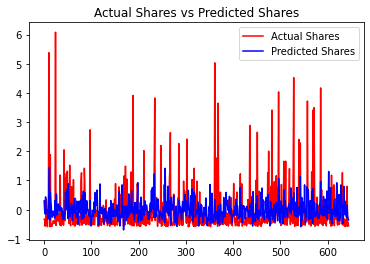

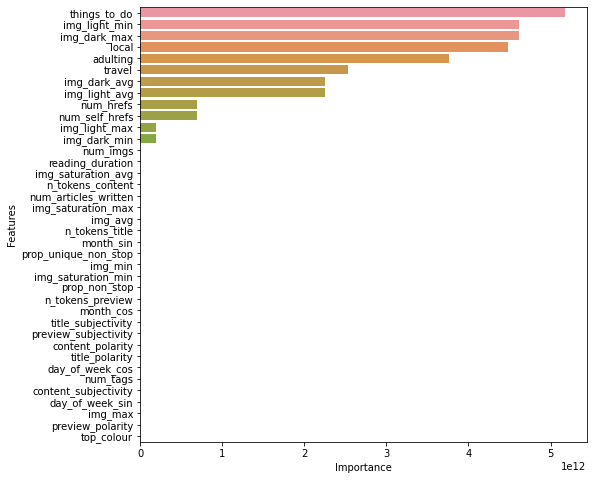

In [31]:
lr_base = train_and_evaluate_model(LinearRegression(),
                                   X_train,
                                   y_train,
                                   X_test,
                                   y_test)

### Model with Feature Selection

Model Evaluation
MAE: 0.5498933621222061, MSE: 0.7382129829910085, RMSE: 0.8591932163320475


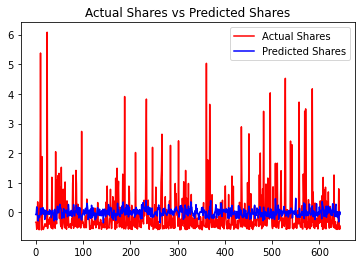

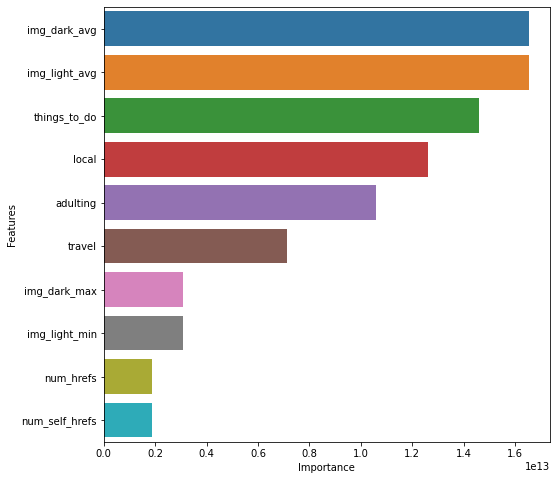

In [32]:
feature = get_impt_feat(abs(lr_base.coef_), X_test, 10)

lr_feature = train_and_evaluate_model(LinearRegression(), X_train[feature], y_train, X_test[feature], y_test)

## XGB Regression

### Base Model

Model Evaluation
MAE: 0.5582898145613342, MSE: 0.8006009440462496, RMSE: 0.8947630658706525


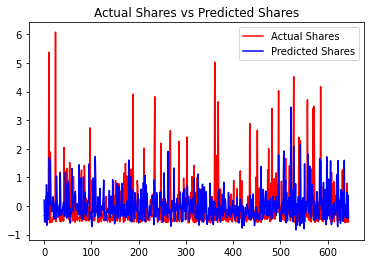

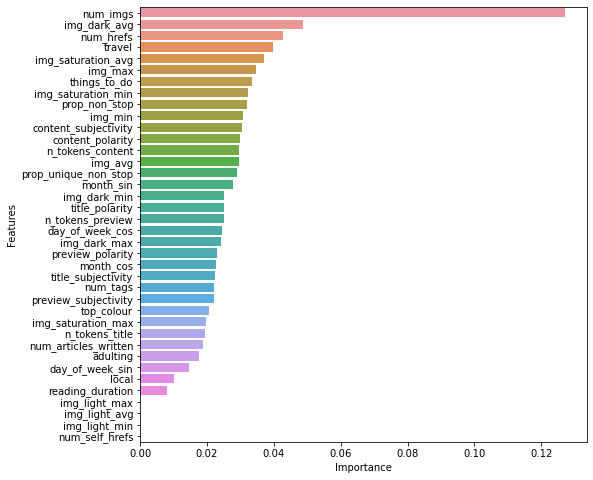

In [33]:
cgb_base = train_and_evaluate_model(XGBRegressor(random_state=rand_state), X_train, y_train, X_test, y_test)

### Model with Feature Selection

Model Evaluation
MAE: 0.5947642194763317, MSE: 0.8634656192183178, RMSE: 0.9292285075363959


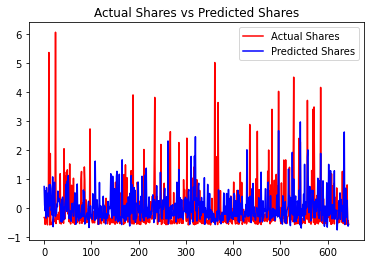

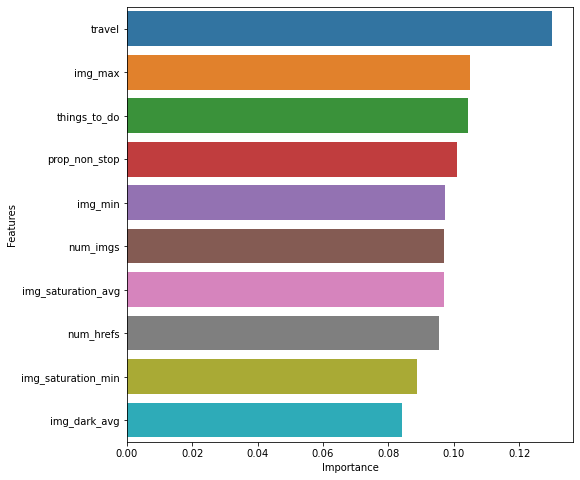

In [34]:
feature = get_impt_feat(cgb_base.feature_importances_, X_test, 10)

cgb_feature = train_and_evaluate_model(XGBRegressor(random_state=rand_state),
                                       X_train[feature],
                                       y_train,
                                       X_test[feature],
                                       y_test)

## RandomForestRegressor

### Base Model

Model Evaluation
MAE: 0.5497518181553137, MSE: 0.7252140426559157, RMSE: 0.8515949991961647


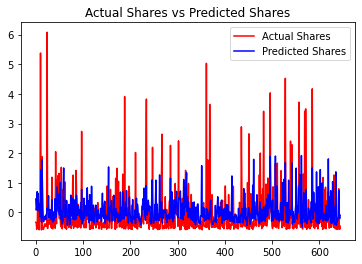

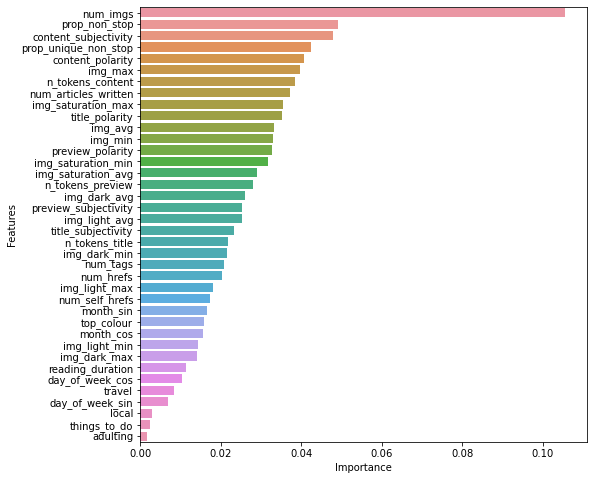

In [35]:
rfr_base = train_and_evaluate_model(RandomForestRegressor(random_state=rand_state),
                                    X_train, y_train, X_test, y_test)

### Model with Feature Selection

Model Evaluation
MAE: 0.5387472774171852, MSE: 0.734675359892109, RMSE: 0.8571320551070931


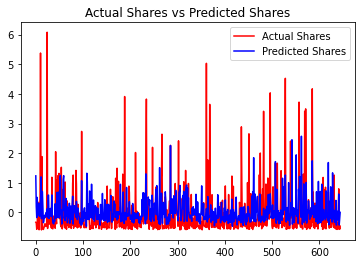

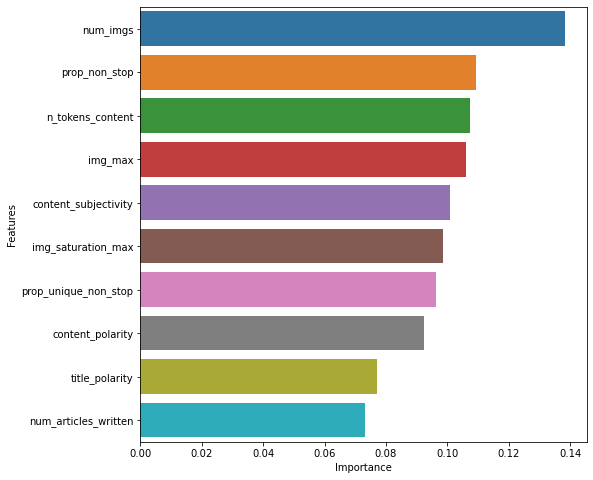

In [36]:
feature = get_impt_feat(rfr_base.feature_importances_, X_test, 10)

rfr_base = train_and_evaluate_model(RandomForestRegressor(random_state=rand_state),
                                    X_train[feature],
                                    y_train,
                                    X_test[feature],
                                    y_test)

# Multi-Class Classification

## Data Preprocessing

### Train - Test split

In [37]:
drop_cols = ['timedelta', 'url', 'title', 'subcategory1', 'subcategory2',
             'subcategory3', 'preview', 'content', 'publish_date', 'img_links',
             'author', 'day_of_week', 'month', 'year', 'num_shares', 'class',
             'img_dark', 'img_light', 'img_saturation', 'top3_colours',
             'bot3_colours']

X = smartlocal.drop(columns=drop_cols)
y = smartlocal['class']

In [38]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=2022,
                                                    shuffle=True,
                                                    stratify=y)

### One Hot Encoding

In [39]:
ohe_enc = OneHotEncoder()
X_train_cat = ohe_enc.fit_transform(X=X_train['category'].to_numpy().reshape(-1, 1))
X_cat_features = [x.lower().replace('x0_', '').replace(' ', '_') for x in
                  ohe_enc.get_feature_names_out()]

X_train_ohe_df = pd.DataFrame(data=X_train_cat.todense(),
                              columns=X_cat_features)

X_train = pd.concat(objs=[X_train.loc[:,'num_articles_written'].reset_index(drop=True),
                          X_train_ohe_df,
                          X_train.loc[:,'n_tokens_title':].reset_index(drop=True)],
                    axis=1)

display_df(df=X_train)

Number of rows: 2772
Number of columns: 38


,num_articles_written,adulting,local,things_to_do,travel,n_tokens_title,title_polarity,title_subjectivity,n_tokens_preview,preview_polarity,...,img_saturation_avg,img_saturation_max,top_colour,img_avg,img_max,img_min,day_of_week_sin,day_of_week_cos,month_sin,month_cos
0,52,0.0,0.0,1.0,0.0,17,0.000,0.000,26,0.375000,...,49.371667,67.86,1896,2.025861,7.387692,0.072191,0.000000e+00,1.0,-1.000000,-1.836970e-16
1,21,0.0,1.0,0.0,0.0,12,0.500,0.500,31,0.250000,...,46.060000,128.88,1896,0.523398,4.227264,0.000010,1.224647e-16,-1.0,1.000000,6.123234e-17
2,452,0.0,0.0,1.0,0.0,15,0.000,0.000,20,0.136364,...,95.804667,149.45,95,1.586863,5.818587,0.153540,8.660254e-01,0.5,1.000000,6.123234e-17
3,150,0.0,0.0,1.0,0.0,12,0.000,0.000,8,0.000000,...,58.887000,122.66,1896,1.436348,7.655211,0.117615,8.660254e-01,-0.5,-0.500000,-8.660254e-01
4,52,0.0,0.0,1.0,0.0,14,-0.075,0.325,23,-0.033333,...,86.202000,164.73,1896,1.787614,5.868506,0.109244,8.660254e-01,-0.5,0.866025,-5.000000e-01


In [40]:
X_test_cat = ohe_enc.transform(X=X_test['category'].to_numpy().reshape(-1, 1))
X_test_ohe_df = pd.DataFrame(data=X_test_cat.todense(),
                             columns=X_cat_features)

X_test = pd.concat(objs=[X_test.loc[:,'num_articles_written'].reset_index(drop=True),
                         X_test_ohe_df,
                         X_test.loc[:,'n_tokens_title':].reset_index(drop=True)],
                   axis=1)

display_df(df=X_test)

Number of rows: 693
Number of columns: 38


,num_articles_written,adulting,local,things_to_do,travel,n_tokens_title,title_polarity,title_subjectivity,n_tokens_preview,preview_polarity,...,img_saturation_avg,img_saturation_max,top_colour,img_avg,img_max,img_min,day_of_week_sin,day_of_week_cos,month_sin,month_cos
0,70,0.0,1.0,0.0,0.0,12,0.000000,0.000000,27,0.000000,...,65.040000,101.82,441,1.535438,5.360823,0.255958,0.866025,0.5,-1.000000,-1.836970e-16
1,150,0.0,0.0,1.0,0.0,17,0.400000,0.400000,11,0.000000,...,63.564444,112.56,1896,1.724166,8.160600,0.070958,-0.866025,-0.5,0.500000,-8.660254e-01
2,16,0.0,1.0,0.0,0.0,17,0.000000,0.300000,29,0.045455,...,101.406000,150.63,1896,1.226048,4.938405,0.079557,0.866025,-0.5,0.500000,8.660254e-01
3,21,1.0,0.0,0.0,0.0,16,1.000000,0.300000,27,0.225000,...,63.300556,116.86,441,0.844007,4.588703,0.024761,0.866025,-0.5,1.000000,6.123234e-17
4,452,0.0,0.0,1.0,0.0,18,0.110606,0.340909,31,0.241667,...,39.102727,84.16,441,0.822597,4.575244,0.006109,0.866025,-0.5,-0.866025,-5.000000e-01


### Feature Scaling
Some of the classifier need to use scaled features.

In [41]:
scaler = StandardScaler()

X_train_scaled = pd.DataFrame(scaler.fit_transform(X=X_train),
                              columns=X_train.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X=X_test),
                             columns=X_test.columns)

## Utility Functions

In [42]:
def evaluate_model(y_true, y_pred):
    """Prints a classification report and plots a confusion matrix."""
    labels = ['0', '1', '2']

    print(classification_report(y_true=y_true,
                                y_pred=y_pred,
                                target_names=labels))

    cm = confusion_matrix(y_true=y_true,
                          y_pred=y_pred,
                          labels=[0, 1, 2])

    plt.imshow(cm, cmap=plt.cm.Blues)
    threshold = cm.min() + ((cm.max() - cm.min()) / 2)

    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]): 
            plt.text(x=j, y=i, s=cm[i,j], 
                     color='w' if cm[i,j] > threshold else 'black',
                     fontsize=16, ha='center', va='center')

    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels)
    plt.yticks(tick_marks, labels)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(b=None)
    plt.colorbar()
    plt.tight_layout()

def get_mean_cvs(model, X, y):
    cv = RepeatedStratifiedKFold(n_splits=10,
                                 n_repeats=3,
                                 random_state=rand_state)
    
    scores = cross_val_score(model, X, y,
                             scoring='accuracy',
                             cv=cv,
                             n_jobs=-1,
                             error_score='raise')
    
    print('Cross Validation Score: %f (%f)' % (scores.mean(), scores.std()))
    
    return scores
    
def get_best_params(model, grid, X, y, is_iterate_all):
    # Estimates model performance
    cv = RepeatedStratifiedKFold(n_splits=10,
                                 n_repeats=3,
                                 random_state=rand_state)

    if is_iterate_all:
        # Tries all combinations of hyperparameters specified in grid to
        # get best parameters
        scv = GridSearchCV(estimator=model,
                           param_grid=grid,
                           n_jobs=-1,
                           cv=cv,
                           scoring='accuracy',
                           error_score=0)
    else:
        scv = RandomizedSearchCV(estimator=model,
                                 param_distributions=grid,
                                 n_iter=10,
                                 n_jobs=-1,
                                 cv=None,
                                 random_state=rand_state)
    
    grid_result = scv.fit(X, y)
    
    # Results summary
    print('Best: %f using %s' % (grid_result.best_score_,
                                 grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print('%f (%f) with: %r' % (mean, stdev, param))
        
    return grid_result.best_params_

def get_top_feat(model, X, y):
    models = dict()
    for i in range(2, X.shape[1] + 1, 4):
        rfe = RFE(estimator=copy.deepcopy(model), n_features_to_select=i)
        models[str(i)] = Pipeline(steps=[('rfe',rfe),('m',model)])
    
    results, features = list(), list()
    for num_features, m in models.items():
        print(f'Number of Features Selected: {num_features}')
        scores = get_mean_cvs(model=m, X=X, y=y)
        results.append(scores)
        features.append(num_features)

    # Plot Boxplot of Performance Across Number of Features Selected
    g = sns.boxplot(data=results)
    g.set(xlabel='Number of Features', ylabel='Cross Validation Score')
    plt.xticks(ticks=range(len(features)), labels=features)
    plt.show()
    
    best_index = np.argmax(a=[x.mean() for x in results])
    rfe = RFE(estimator=model, n_features_to_select=int(features[best_index]))
    rfe.fit(X, y)

    return sorted(zip(rfe.ranking_, X.columns))

## Logistic Regression
The tuning process is referenced from [Jason Brownlee](https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/)

### Base Model A:0.434 F1:0.42

Cross Validation Score: 0.441812 (0.027542)
Accuracy: 0.43434343434343436
              precision    recall  f1-score   support

           0       0.44      0.54      0.48       231
           1       0.37      0.26      0.30       231
           2       0.47      0.51      0.49       231

    accuracy                           0.43       693
   macro avg       0.43      0.43      0.42       693
weighted avg       0.43      0.43      0.42       693



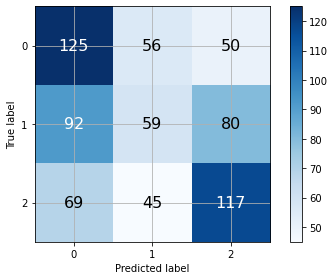

In [43]:
lr_base_model = LogisticRegression(random_state=rand_state)

# Cross Validation Scores
get_mean_cvs(lr_base_model, X_train_scaled, y_train)

lr_base_model.fit(X_train_scaled, y_train)
print(f'Accuracy: {lr_base_model.score(X_test_scaled, y_test)}')

y_test_pred_lr_base = lr_base_model.predict(X_test_scaled)
evaluate_model(y_true=y_test, y_pred=y_test_pred_lr_base)

### Model with Best Parameters A:0.447 F1:0.44

In [44]:
grid = dict(solver=['newton-cg', 'lbfgs', 'liblinear'],
            penalty=['l2'],
            C=np.logspace(start=-3, stop=2, num=6))

lr_best_params = get_best_params(model=LogisticRegression(random_state=rand_state),
                                 grid=grid,
                                 X=X_train_scaled,
                                 y=y_train,
                                 is_iterate_all=True)

Best: 0.446019 using {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.439162 (0.024266) with: {'C': 0.001, 'penalty': 'l2', 'solver': 'newton-cg'}
0.439162 (0.024266) with: {'C': 0.001, 'penalty': 'l2', 'solver': 'lbfgs'}
0.437838 (0.026530) with: {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
0.443973 (0.023087) with: {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}
0.444093 (0.023125) with: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
0.444695 (0.023381) with: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
0.443494 (0.023952) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.443494 (0.023952) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.446019 (0.024717) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.441933 (0.027623) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.441812 (0.027542) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.442896 (0.027669) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.440489 (0

Cross Validation Score: 0.446019 (0.024717)
Accuracy: 0.44733044733044736
              precision    recall  f1-score   support

           0       0.45      0.56      0.50       231
           1       0.39      0.26      0.31       231
           2       0.47      0.53      0.50       231

    accuracy                           0.45       693
   macro avg       0.44      0.45      0.44       693
weighted avg       0.44      0.45      0.44       693



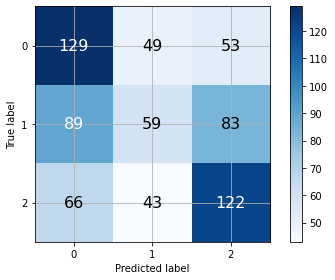

In [45]:
lr_tuned_model = LogisticRegression(penalty=lr_best_params['penalty'],
                                    C=lr_best_params['C'],
                                    solver=lr_best_params['solver'],
                                    random_state=rand_state)

# Cross Validation Scores
get_mean_cvs(lr_tuned_model, X_train_scaled, y_train)

lr_tuned_model.fit(X_train_scaled, y_train)
print(f'Accuracy: {lr_tuned_model.score(X_test_scaled, y_test)}')

y_test_pred_lr_tuned = lr_tuned_model.predict(X_test_scaled)
evaluate_model(y_true=y_test, y_pred=y_test_pred_lr_tuned)

### Model with Feature Selection A:0.431 F1:0.42

Number of Features Selected: 2
Cross Validation Score: 0.425577 (0.032092)
Number of Features Selected: 6
Cross Validation Score: 0.444568 (0.022070)
Number of Features Selected: 10
Cross Validation Score: 0.447937 (0.024963)
Number of Features Selected: 14
Cross Validation Score: 0.446376 (0.025062)
Number of Features Selected: 18
Cross Validation Score: 0.445173 (0.024758)
Number of Features Selected: 22
Cross Validation Score: 0.442411 (0.023085)
Number of Features Selected: 26
Cross Validation Score: 0.441326 (0.024510)
Number of Features Selected: 30
Cross Validation Score: 0.442409 (0.026747)
Number of Features Selected: 34
Cross Validation Score: 0.443616 (0.027728)
Number of Features Selected: 38
Cross Validation Score: 0.441812 (0.027542)


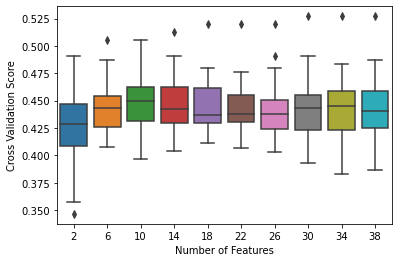

In [46]:
lr_top_features = get_top_feat(model=LogisticRegression(random_state=rand_state),
                               X=X_train_scaled,
                               y=y_train)

In [47]:
# 10 Features
top_feat = [feat for rank, feat in lr_top_features if rank in [1]]

grid = dict(solver=['newton-cg', 'lbfgs', 'liblinear'],
            penalty=['l2'],
            C=np.logspace(start=-3, stop=2, num=6))

lr_feat_params = get_best_params(model=LogisticRegression(random_state=rand_state),
                                 grid=grid,
                                 X=X_train_scaled[top_feat],
                                 y=y_train,
                                 is_iterate_all=True)

Best: 0.461401 using {'C': 10.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.453704 (0.029369) with: {'C': 0.001, 'penalty': 'l2', 'solver': 'newton-cg'}
0.453704 (0.029369) with: {'C': 0.001, 'penalty': 'l2', 'solver': 'lbfgs'}
0.446853 (0.029606) with: {'C': 0.001, 'penalty': 'l2', 'solver': 'liblinear'}
0.458155 (0.024411) with: {'C': 0.01, 'penalty': 'l2', 'solver': 'newton-cg'}
0.458155 (0.024411) with: {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}
0.458637 (0.022873) with: {'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}
0.457795 (0.025476) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.457554 (0.025503) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.456474 (0.023099) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.460201 (0.025347) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.460201 (0.025347) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.459116 (0.023846) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.461281 (0.02

Cross Validation Score: 0.461401 (0.025429)
Accuracy: 0.4314574314574315
              precision    recall  f1-score   support

           0       0.44      0.58      0.50       231
           1       0.34      0.23      0.27       231
           2       0.48      0.49      0.48       231

    accuracy                           0.43       693
   macro avg       0.42      0.43      0.42       693
weighted avg       0.42      0.43      0.42       693



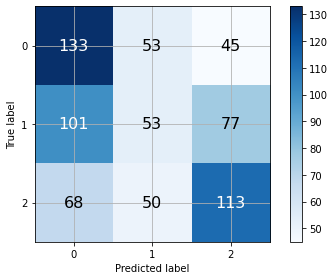

In [48]:
lr_feat_model = LogisticRegression(penalty=lr_feat_params['penalty'],
                                   C=lr_feat_params['C'],
                                   solver=lr_feat_params['solver'],
                                   random_state=rand_state)

# Cross Validation Scores
get_mean_cvs(lr_feat_model, X_train_scaled[top_feat], y_train)

lr_feat_model.fit(X_train_scaled[top_feat], y_train)
print(f'Accuracy: {lr_feat_model.score(X_test_scaled[top_feat], y_test)}')

y_test_pred_lr_feat = lr_feat_model.predict(X_test_scaled[top_feat])
evaluate_model(y_true=y_test, y_pred=y_test_pred_lr_feat)

In [49]:
# No specific order
top_feat

['img_avg',
 'img_max',
 'img_saturation_max',
 'n_tokens_content',
 'n_tokens_preview',
 'n_tokens_title',
 'num_articles_written',
 'num_imgs',
 'reading_duration',
 'title_polarity']

## Support Vector Classifier

### Base Model A:0.446 F1:0.44

Cross Validation Score: 0.422447 (0.029358)
Accuracy: 0.4458874458874459
              precision    recall  f1-score   support

           0       0.45      0.55      0.49       231
           1       0.37      0.30      0.33       231
           2       0.51      0.48      0.50       231

    accuracy                           0.45       693
   macro avg       0.44      0.45      0.44       693
weighted avg       0.44      0.45      0.44       693



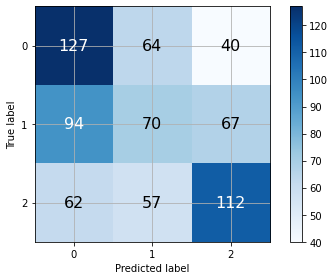

In [50]:
svm_base_clf = SVC(random_state=rand_state)

# Cross Validation Scores
get_mean_cvs(svm_base_clf, X_train_scaled, y_train)

svm_base_clf.fit(X_train_scaled, y_train)
print(f'Accuracy: {svm_base_clf.score(X_test_scaled, y_test)}')

y_test_pred_svm_base = svm_base_clf.predict(X_test_scaled)
evaluate_model(y_true=y_test, y_pred=y_test_pred_svm_base)

### Model with Best Params A:0.455, F1:0.45

In [51]:
grid = dict(C=np.logspace(start=-3, stop=2, num=6),
            kernel=['poly', 'rbf', 'sigmoid'],
            gamma=['scale'])

svm_best_params = get_best_params(model=SVC(random_state=rand_state),
                                  grid=grid,
                                  X=X_train_scaled,
                                  y=y_train,
                                  is_iterate_all=False)

Best: 0.424240 using {'kernel': 'rbf', 'gamma': 'scale', 'C': 0.1}
0.335134 (0.003420) with: {'kernel': 'poly', 'gamma': 'scale', 'C': 0.01}
0.334415 (0.000588) with: {'kernel': 'rbf', 'gamma': 'scale', 'C': 0.01}
0.376272 (0.030788) with: {'kernel': 'sigmoid', 'gamma': 'scale', 'C': 100.0}
0.334776 (0.000721) with: {'kernel': 'poly', 'gamma': 'scale', 'C': 0.001}
0.372283 (0.016257) with: {'kernel': 'poly', 'gamma': 'scale', 'C': 0.1}
0.408731 (0.009665) with: {'kernel': 'poly', 'gamma': 'scale', 'C': 1.0}
0.424240 (0.013262) with: {'kernel': 'rbf', 'gamma': 'scale', 'C': 0.1}
0.387450 (0.008958) with: {'kernel': 'rbf', 'gamma': 'scale', 'C': 100.0}
0.381322 (0.011608) with: {'kernel': 'poly', 'gamma': 'scale', 'C': 100.0}
0.392133 (0.009033) with: {'kernel': 'poly', 'gamma': 'scale', 'C': 10.0}


Cross Validation Score: 0.424615 (0.025894)
Accuracy: 0.45454545454545453
              precision    recall  f1-score   support

           0       0.47      0.57      0.51       231
           1       0.38      0.33      0.35       231
           2       0.50      0.47      0.49       231

    accuracy                           0.45       693
   macro avg       0.45      0.45      0.45       693
weighted avg       0.45      0.45      0.45       693



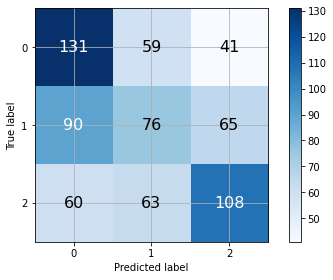

In [52]:
svm_tuned_clf = SVC(C=svm_best_params['C'],
                    kernel=svm_best_params['kernel'],
                    gamma=svm_best_params['gamma'],
                    random_state=rand_state)

# Cross Validation Scores
get_mean_cvs(svm_tuned_clf, X_train_scaled, y_train)

svm_tuned_clf.fit(X_train_scaled, y_train)
print(f'Accuracy: {svm_tuned_clf.score(X_test_scaled, y_test)}')

y_test_pred_svm_tuned = svm_tuned_clf.predict(X_test_scaled)
evaluate_model(y_true=y_test, y_pred=y_test_pred_svm_tuned)

### Model with Feature Selection A:0.456 F1:0.45

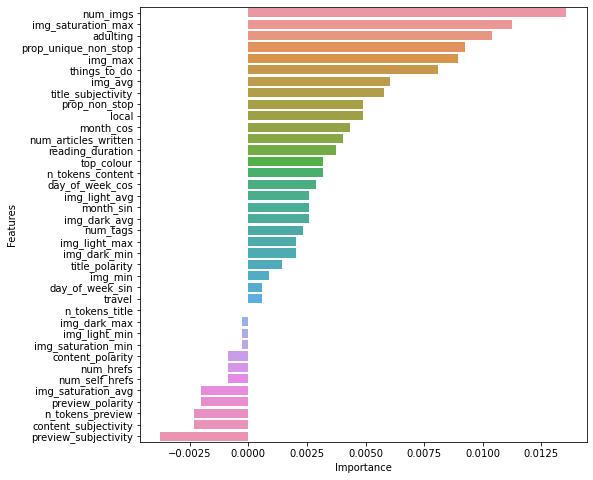

In [53]:
permutation_impt = permutation_importance(estimator=svm_tuned_clf,
                                          X=X_test_scaled,
                                          y=y_test,
                                          random_state=rand_state)
feature_impt = (pd.DataFrame({'Features': X_test_scaled.columns,
                              'Importance': permutation_impt.importances_mean})
                  .sort_values(by='Importance', ascending=False))

plt.figure(figsize=(8,8))
sns.barplot(x='Importance', y='Features', data=feature_impt)
plt.show()

Number of Features Selected: 2
Cross Validation Score: 0.432772 (0.027666)
Number of Features Selected: 6
Cross Validation Score: 0.428341 (0.023459)
Number of Features Selected: 10
Cross Validation Score: 0.435429 (0.032392)
Number of Features Selected: 14
Cross Validation Score: 0.427371 (0.026820)
Number of Features Selected: 18
Cross Validation Score: 0.426411 (0.030913)
Number of Features Selected: 22
Cross Validation Score: 0.418234 (0.028224)
Number of Features Selected: 26
Cross Validation Score: 0.424136 (0.031937)
Number of Features Selected: 30
Cross Validation Score: 0.420159 (0.028622)
Number of Features Selected: 34
Cross Validation Score: 0.417631 (0.029383)
Number of Features Selected: 38
Cross Validation Score: 0.422447 (0.029358)


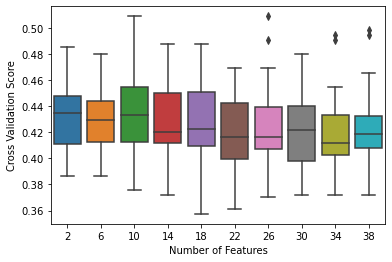

In [54]:
results, features = list(), list()

for i in range(2, X_train.shape[1] + 1, 4):
    print(f'Number of Features Selected: {i}')
    svm_temp_clf = SVC(random_state=rand_state)

    # Cross Validation Scores
    scores = get_mean_cvs(svm_temp_clf,
                          X_train_scaled[feature_impt.Features[:i]],
                          y_train)

    results.append(scores)
    features.append(i)

# Plot Boxplot of Performance Across Number of Features Selected
g = sns.boxplot(data=results)
g.set(xlabel='Number of Features', ylabel='Cross Validation Score')
plt.xticks(ticks=range(len(features)), labels=features)
plt.show()

best_index = np.argmax(a=[x.mean() for x in results])
top_feat_svm = feature_impt.Features[:features[best_index]]

In [55]:
top_feat_svm.tolist()

['num_imgs',
 'img_saturation_max',
 'adulting',
 'prop_unique_non_stop',
 'img_max',
 'things_to_do',
 'img_avg',
 'title_subjectivity',
 'prop_non_stop',
 'local']

In [56]:
grid = dict(C=np.logspace(start=-3, stop=2, num=6),
            kernel=['poly', 'rbf', 'sigmoid'],
            gamma=['scale'])

feat_params = get_best_params(model=SVC(random_state=rand_state),
                              grid=grid,
                              X=X_train_scaled[top_feat_svm],
                              y=y_train,
                              is_iterate_all=False)

Best: 0.430020 using {'kernel': 'rbf', 'gamma': 'scale', 'C': 0.1}
0.353183 (0.012752) with: {'kernel': 'poly', 'gamma': 'scale', 'C': 0.01}
0.340906 (0.006389) with: {'kernel': 'rbf', 'gamma': 'scale', 'C': 0.01}
0.380591 (0.028387) with: {'kernel': 'sigmoid', 'gamma': 'scale', 'C': 100.0}
0.334776 (0.000721) with: {'kernel': 'poly', 'gamma': 'scale', 'C': 0.001}
0.401153 (0.011038) with: {'kernel': 'poly', 'gamma': 'scale', 'C': 0.1}
0.418833 (0.024627) with: {'kernel': 'poly', 'gamma': 'scale', 'C': 1.0}
0.430020 (0.007825) with: {'kernel': 'rbf', 'gamma': 'scale', 'C': 0.1}
0.399711 (0.011640) with: {'kernel': 'rbf', 'gamma': 'scale', 'C': 100.0}
0.408007 (0.021153) with: {'kernel': 'poly', 'gamma': 'scale', 'C': 100.0}
0.405835 (0.029438) with: {'kernel': 'poly', 'gamma': 'scale', 'C': 10.0}


Cross Validation Score: 0.425212 (0.023417)
Accuracy: 0.455988455988456
              precision    recall  f1-score   support

           0       0.47      0.57      0.51       231
           1       0.38      0.33      0.35       231
           2       0.50      0.47      0.49       231

    accuracy                           0.45       693
   macro avg       0.45      0.45      0.45       693
weighted avg       0.45      0.45      0.45       693



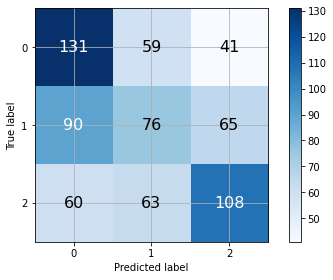

In [57]:
svm_feat_clf = SVC(C=feat_params['C'],
                    kernel=feat_params['kernel'],
                    gamma=feat_params['gamma'],
                    random_state=rand_state)

# Cross Validation Scores
get_mean_cvs(svm_feat_clf, X_train_scaled[top_feat_svm], y_train)

svm_feat_clf.fit(X_train_scaled[top_feat_svm], y_train)
print(f'Accuracy: {svm_feat_clf.score(X_test_scaled[top_feat_svm], y_test)}')

y_test_pred_svm_feat = svm_feat_clf.predict(X_test_scaled[top_feat_svm])
evaluate_model(y_true=y_test, y_pred=y_test_pred_svm_tuned)

## Decision Tree

### Base Model A:0.397 F1:0.39

Cross Validation Score: 0.390449 (0.024642)
Accuracy: 0.3968253968253968
              precision    recall  f1-score   support

           0       0.42      0.44      0.43       231
           1       0.35      0.31      0.33       231
           2       0.41      0.44      0.43       231

    accuracy                           0.40       693
   macro avg       0.39      0.40      0.39       693
weighted avg       0.39      0.40      0.39       693



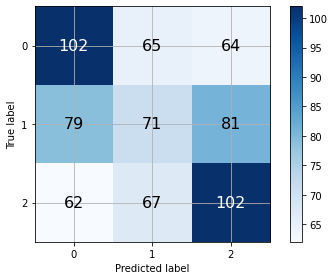

In [58]:
dc_base_clf = DecisionTreeClassifier(random_state=rand_state)

# Cross Validation Scores
get_mean_cvs(dc_base_clf, X_train, y_train)

dc_base_clf.fit(X_train, y_train)
print(f'Accuracy: {dc_base_clf.score(X_test, y_test)}')

y_test_pred_dc_base = dc_base_clf.predict(X_test)
evaluate_model(y_true=y_test, y_pred=y_test_pred_dc_base)

### Model with Best Params A:0.378 F1:0.38

In [59]:
grid = dict(max_depth=[int(x) for x in np.linspace(start=10, stop=110, num = 11)] + [None],
            min_samples_split=[2, 5, 10],
            min_samples_leaf=[1, 2, 4],
            max_features = ['auto', 'sqrt'])

dc_best_params = get_best_params(model=DecisionTreeClassifier(random_state=rand_state),
                                 grid=grid,
                                 X=X_train,
                                 y=y_train,
                                 is_iterate_all=False)

Best: 0.390683 using {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 70}
0.375171 (0.020886) with: {'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 40}
0.377688 (0.023830) with: {'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 90}
0.390683 (0.015880) with: {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 70}
0.375171 (0.020886) with: {'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 70}
0.384207 (0.016445) with: {'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 90}
0.384207 (0.016445) with: {'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 100}
0.380583 (0.011412) with: {'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 50}
0.377688 (0.023830) with: {'min_samples_split': 2, 'min_samples_leaf': 4, 'max_fe

Cross Validation Score: 0.379752 (0.027080)
Accuracy: 0.37806637806637805
              precision    recall  f1-score   support

           0       0.35      0.34      0.35       231
           1       0.38      0.41      0.39       231
           2       0.40      0.39      0.39       231

    accuracy                           0.38       693
   macro avg       0.38      0.38      0.38       693
weighted avg       0.38      0.38      0.38       693



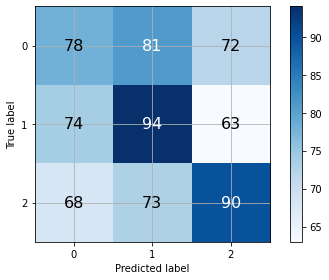

In [60]:
dc_tuned_clf = DecisionTreeClassifier(
    max_depth=dc_best_params['max_depth'],
    min_samples_split=dc_best_params['min_samples_split'],
    min_samples_leaf=dc_best_params['min_samples_leaf'],
    max_features=dc_best_params['max_features'],
    random_state=rand_state
)

# Cross Validation Scores
get_mean_cvs(dc_tuned_clf, X_train, y_train)

dc_tuned_clf.fit(X_train, y_train)
print(f'Accuracy: {dc_tuned_clf.score(X_test, y_test)}')

y_test_pred_dc_tuned = dc_tuned_clf.predict(X_test)
evaluate_model(y_true=y_test, y_pred=y_test_pred_dc_tuned)

### Model with Feature Selection A:0.378 F1:0.38

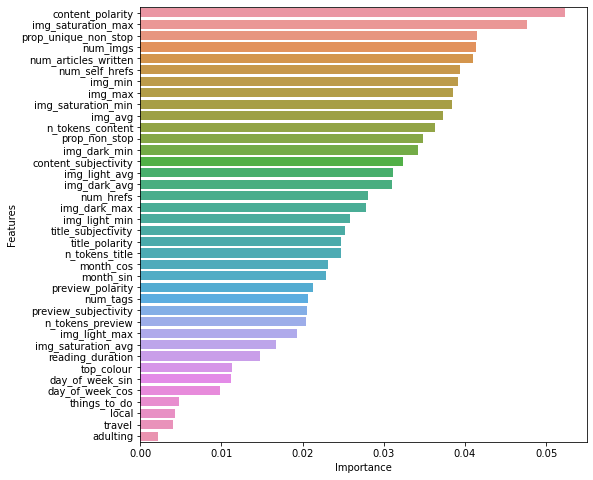

In [61]:
dc_feature_impt = plot_feature_impt(model=dc_tuned_clf, X=X_test)

Number of Features Selected: 2
Cross Validation Score: 0.329721 (0.031492)
Number of Features Selected: 6
Cross Validation Score: 0.381314 (0.033647)
Number of Features Selected: 10
Cross Validation Score: 0.379147 (0.027593)
Number of Features Selected: 14
Cross Validation Score: 0.385159 (0.026818)
Number of Features Selected: 18
Cross Validation Score: 0.383837 (0.033374)
Number of Features Selected: 22
Cross Validation Score: 0.393097 (0.030016)
Number of Features Selected: 26
Cross Validation Score: 0.388894 (0.031878)
Number of Features Selected: 30
Cross Validation Score: 0.388044 (0.031422)
Number of Features Selected: 34
Cross Validation Score: 0.384680 (0.026166)
Number of Features Selected: 38
Cross Validation Score: 0.382270 (0.025647)


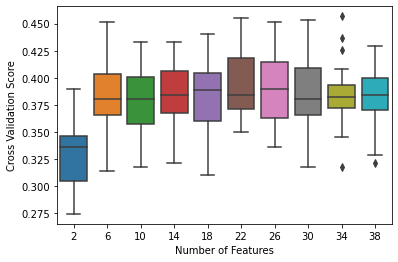

In [62]:
results, features = list(), list()

for i in range(2, X_train.shape[1] + 1, 4):
    print(f'Number of Features Selected: {i}')
    dc_temp_clf = DecisionTreeClassifier(random_state=rand_state)

    # Cross Validation Scores
    scores = get_mean_cvs(dc_temp_clf,
                          X_train[dc_feature_impt.Features[:i]],
                          y_train)

    results.append(scores)
    features.append(i)

# Plot Boxplot of Performance Across Number of Features Selected
g = sns.boxplot(data=results)
g.set(xlabel='Number of Features', ylabel='Cross Validation Score')
plt.xticks(ticks=range(len(features)), labels=features)
plt.show()

best_index = np.argmax(a=[x.mean() for x in results])
top_feat_dc = dc_feature_impt.Features[:features[best_index]]

In [63]:
top_feat_dc.tolist()

['content_polarity',
 'img_saturation_max',
 'prop_unique_non_stop',
 'num_imgs',
 'num_articles_written',
 'num_self_hrefs',
 'img_min',
 'img_max',
 'img_saturation_min',
 'img_avg',
 'n_tokens_content',
 'prop_non_stop',
 'img_dark_min',
 'content_subjectivity',
 'img_light_avg',
 'img_dark_avg',
 'num_hrefs',
 'img_dark_max',
 'img_light_min',
 'title_subjectivity',
 'title_polarity',
 'n_tokens_title']

In [64]:
grid = dict(max_depth=[int(x) for x in np.linspace(start=10, stop=110, num = 11)] + [None],
            min_samples_split=[2, 5, 10],
            min_samples_leaf=[1, 2, 4],
            max_features = ['auto', 'sqrt'])

dc_feat_params = get_best_params(model=DecisionTreeClassifier(random_state=rand_state),
                                 grid=grid,
                                 X=X_train,
                                 y=y_train,
                                 is_iterate_all=False)

Best: 0.390683 using {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 70}
0.375171 (0.020886) with: {'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 40}
0.377688 (0.023830) with: {'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 90}
0.390683 (0.015880) with: {'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 70}
0.375171 (0.020886) with: {'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': 70}
0.384207 (0.016445) with: {'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 90}
0.384207 (0.016445) with: {'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 100}
0.380583 (0.011412) with: {'min_samples_split': 10, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 50}
0.377688 (0.023830) with: {'min_samples_split': 2, 'min_samples_leaf': 4, 'max_fe

Cross Validation Score: 0.379752 (0.027080)
Accuracy: 0.37806637806637805
              precision    recall  f1-score   support

           0       0.35      0.34      0.35       231
           1       0.38      0.41      0.39       231
           2       0.40      0.39      0.39       231

    accuracy                           0.38       693
   macro avg       0.38      0.38      0.38       693
weighted avg       0.38      0.38      0.38       693



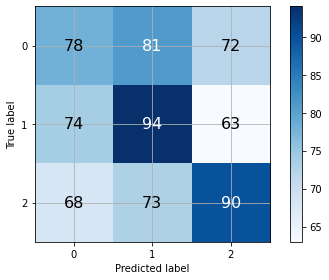

In [65]:
dc_feat_clf = DecisionTreeClassifier(
    max_depth=dc_feat_params['max_depth'],
    min_samples_split=dc_feat_params['min_samples_split'],
    min_samples_leaf=dc_feat_params['min_samples_leaf'],
    max_features=dc_feat_params['max_features'],
    random_state=rand_state
)

# Cross Validation Scores
get_mean_cvs(dc_feat_clf, X_train, y_train)

dc_feat_clf.fit(X_train, y_train)
print(f'Accuracy: {dc_feat_clf.score(X_test, y_test)}')

y_test_pred_dc_feat = dc_feat_clf.predict(X_test)
evaluate_model(y_true=y_test, y_pred=y_test_pred_dc_feat)

## K Neighbors Classifier

### Base Model A:0.414 F1: 0.41

Cross Validation Score: 0.384078 (0.026716)
Accuracy: 0.41414141414141414
              precision    recall  f1-score   support

           0       0.41      0.49      0.45       231
           1       0.37      0.37      0.37       231
           2       0.48      0.38      0.43       231

    accuracy                           0.41       693
   macro avg       0.42      0.41      0.41       693
weighted avg       0.42      0.41      0.41       693



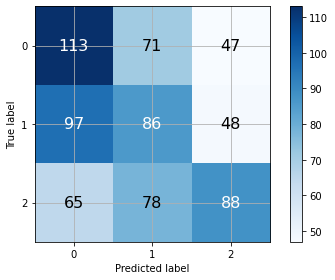

In [66]:
# There is no random_state parameter
knn_clf = KNeighborsClassifier()

# Cross Validation Scores
get_mean_cvs(knn_clf, X_train_scaled, y_train)

knn_clf.fit(X_train_scaled, y_train)
print(f'Accuracy: {knn_clf.score(X_test_scaled, y_test)}')

y_test_pred_knn_base = knn_clf.predict(X_test_scaled)
evaluate_model(y_true=y_test, y_pred=y_test_pred_knn_base)

### Model with Best Params A:0.405 F1:0.40

In [67]:
grid = dict(n_neighbors = range(1, 21, 2),
            weights = ['uniform', 'distance'],
            metric = ['euclidean', 'manhattan', 'minkowski'])

knn_best_params = get_best_params(model=KNeighborsClassifier(),
                                  grid=grid,
                                  X=X_train_scaled,
                                  y=y_train,
                                  is_iterate_all=True)

Best: 0.413904 using {'metric': 'manhattan', 'n_neighbors': 9, 'weights': 'uniform'}
0.370614 (0.025015) with: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
0.370614 (0.025015) with: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'distance'}
0.376626 (0.022373) with: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
0.378068 (0.024126) with: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
0.384078 (0.026716) with: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}
0.391774 (0.024355) with: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}
0.389375 (0.024777) with: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'uniform'}
0.396597 (0.028028) with: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}
0.396356 (0.025120) with: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'uniform'}
0.398162 (0.024339) with: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'distance'}
0.400565 (

Cross Validation Score: 0.413904 (0.021783)
Accuracy: 0.4054834054834055
              precision    recall  f1-score   support

           0       0.40      0.49      0.44       231
           1       0.35      0.25      0.29       231
           2       0.46      0.47      0.46       231

    accuracy                           0.41       693
   macro avg       0.40      0.41      0.40       693
weighted avg       0.40      0.41      0.40       693



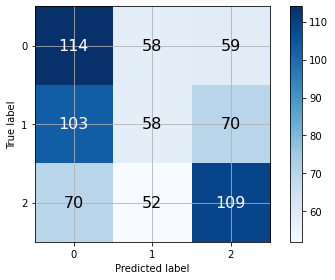

In [68]:
knn_tuned_clf = KNeighborsClassifier(
    n_neighbors=knn_best_params['n_neighbors'],
    weights=knn_best_params['weights'],
    metric=knn_best_params['metric']
)

# Cross Validation Scores
get_mean_cvs(knn_tuned_clf, X_train_scaled, y_train)

knn_tuned_clf.fit(X_train_scaled, y_train)
print(f'Accuracy: {knn_tuned_clf.score(X_test_scaled, y_test)}')

y_test_pred_knn_tuned = knn_tuned_clf.predict(X_test_scaled)
evaluate_model(y_true=y_test, y_pred=y_test_pred_knn_tuned)

### Model with Feature Selection A:0.431 F1:0.43

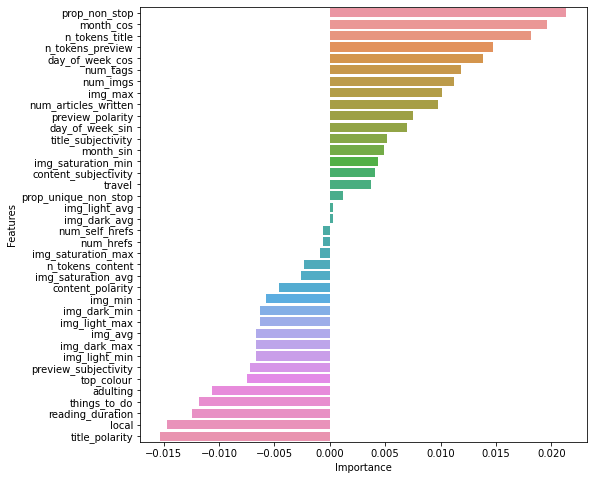

In [69]:
knn_permutation_impt = permutation_importance(estimator=knn_tuned_clf,
                                              X=X_test_scaled,
                                              y=y_test,
                                              random_state=rand_state)
knn_feature_impt = (pd.DataFrame({'Features': X_test_scaled.columns,
                                  'Importance': knn_permutation_impt.importances_mean})
                    .sort_values(by='Importance', ascending=False))

plt.figure(figsize=(8,8))
sns.barplot(x='Importance', y='Features', data=knn_feature_impt)
plt.show()

Number of Features Selected: 2
Cross Validation Score: 0.332250 (0.029310)
Number of Features Selected: 6
Cross Validation Score: 0.337918 (0.028891)
Number of Features Selected: 10
Cross Validation Score: 0.387807 (0.030293)
Number of Features Selected: 14
Cross Validation Score: 0.396457 (0.021449)
Number of Features Selected: 18
Cross Validation Score: 0.394310 (0.021300)
Number of Features Selected: 22
Cross Validation Score: 0.406926 (0.024193)
Number of Features Selected: 26
Cross Validation Score: 0.393572 (0.026572)
Number of Features Selected: 30
Cross Validation Score: 0.389241 (0.025267)
Number of Features Selected: 34
Cross Validation Score: 0.389970 (0.024754)
Number of Features Selected: 38
Cross Validation Score: 0.384078 (0.026716)


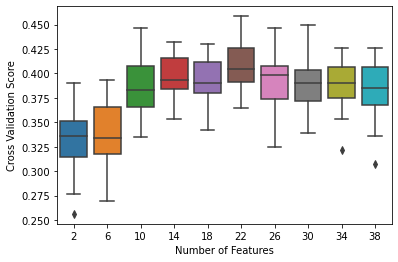

In [70]:
results, features = list(), list()

for i in range(2, X_train.shape[1] + 1, 4):
    print(f'Number of Features Selected: {i}')
    knn_temp_clf = KNeighborsClassifier()

    # Cross Validation Scores
    scores = get_mean_cvs(knn_temp_clf,
                          X_train_scaled[knn_feature_impt.Features[:i]],
                          y_train)

    results.append(scores)
    features.append(i)

# Plot Boxplot of Performance Across Number of Features Selected
g = sns.boxplot(data=results)
g.set(xlabel='Number of Features', ylabel='Cross Validation Score')
plt.xticks(ticks=range(len(features)), labels=features)
plt.show()

best_index = np.argmax(a=[x.mean() for x in results])
top_feat_knn = knn_feature_impt.Features[:features[best_index]]

In [71]:
top_feat_knn.tolist()

['prop_non_stop',
 'month_cos',
 'n_tokens_title',
 'n_tokens_preview',
 'day_of_week_cos',
 'num_tags',
 'num_imgs',
 'img_max',
 'num_articles_written',
 'preview_polarity',
 'day_of_week_sin',
 'title_subjectivity',
 'month_sin',
 'img_saturation_min',
 'content_subjectivity',
 'travel',
 'prop_unique_non_stop',
 'img_light_avg',
 'img_dark_avg',
 'num_self_hrefs',
 'num_hrefs',
 'img_saturation_max']

In [72]:
grid = dict(n_neighbors = range(1, 21, 2),
            weights = ['uniform', 'distance'],
            metric = ['euclidean', 'manhattan', 'minkowski'])

knn_feat_params = get_best_params(model=KNeighborsClassifier(),
                                  grid=grid,
                                  X=X_train_scaled[top_feat_knn],
                                  y=y_train,
                                  is_iterate_all=True)

Best: 0.427962 using {'metric': 'manhattan', 'n_neighbors': 17, 'weights': 'distance'}
0.401753 (0.029023) with: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'uniform'}
0.401753 (0.029023) with: {'metric': 'euclidean', 'n_neighbors': 1, 'weights': 'distance'}
0.410062 (0.027120) with: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}
0.408973 (0.025354) with: {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'distance'}
0.406926 (0.024193) with: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'uniform'}
0.408613 (0.031393) with: {'metric': 'euclidean', 'n_neighbors': 5, 'weights': 'distance'}
0.401511 (0.023882) with: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'uniform'}
0.404399 (0.023272) with: {'metric': 'euclidean', 'n_neighbors': 7, 'weights': 'distance'}
0.402595 (0.020988) with: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'uniform'}
0.413656 (0.023897) with: {'metric': 'euclidean', 'n_neighbors': 9, 'weights': 'distance'}
0.409205

Cross Validation Score: 0.427962 (0.024094)
Accuracy: 0.4314574314574315
              precision    recall  f1-score   support

           0       0.41      0.51      0.46       231
           1       0.38      0.31      0.34       231
           2       0.50      0.48      0.49       231

    accuracy                           0.43       693
   macro avg       0.43      0.43      0.43       693
weighted avg       0.43      0.43      0.43       693



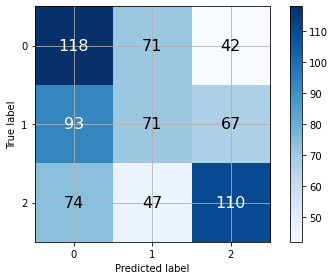

In [73]:
knn_feat_clf = KNeighborsClassifier(
    n_neighbors=knn_feat_params['n_neighbors'],
    weights=knn_feat_params['weights'],
    metric=knn_feat_params['metric']
)

# Cross Validation Scores
get_mean_cvs(knn_feat_clf, X_train_scaled[top_feat_knn], y_train)

knn_feat_clf.fit(X_train_scaled[top_feat_knn], y_train)
print(f'Accuracy: {knn_feat_clf.score(X_test_scaled[top_feat_knn], y_test)}')

y_test_pred_knn_feat = knn_feat_clf.predict(X_test_scaled[top_feat_knn])
evaluate_model(y_true=y_test, y_pred=y_test_pred_knn_feat)

## Random Forest Classifier

### Base Model A:0.433 F1: 0.43

Cross Validation Score: 0.437589 (0.027749)
Accuracy: 0.4329004329004329
              precision    recall  f1-score   support

           0       0.43      0.50      0.47       231
           1       0.35      0.30      0.32       231
           2       0.51      0.49      0.50       231

    accuracy                           0.43       693
   macro avg       0.43      0.43      0.43       693
weighted avg       0.43      0.43      0.43       693



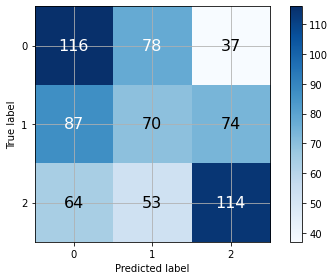

In [74]:
rf_base_clf = RandomForestClassifier(random_state=rand_state)

# Cross Validation Scores
get_mean_cvs(rf_base_clf, X_train, y_train)

rf_base_clf.fit(X_train, y_train)
print(f'Accuracy: {rf_base_clf.score(X_test, y_test)}')

y_test_pred_rf_base = rf_base_clf.predict(X_test)
evaluate_model(y_true=y_test, y_pred=y_test_pred_rf_base)

### Model with Best Params A:0.434 F1:0.43

In [75]:
grid = dict(n_estimators=[10, 100, 1000],
            max_depth=[int(x) for x in np.linspace(start=10, stop=110, num=11)] + [None],
            min_samples_split=[2, 5, 10],
            min_samples_leaf=[1, 2, 4],
            max_features = ['auto', 'sqrt'],
            bootstrap = [True, False])

rf_best_params = get_best_params(model=RandomForestClassifier(random_state=rand_state),
                                 grid=grid,
                                 X=X_train,
                                 y=y_train,
                                 is_iterate_all=False)

Best: 0.440127 using {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 100, 'bootstrap': False}
0.435066 (0.010566) with: {'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 60, 'bootstrap': True}
0.440127 (0.016331) with: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 100, 'bootstrap': False}
0.410169 (0.013957) with: {'n_estimators': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': False}
0.440127 (0.016331) with: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 110, 'bootstrap': False}
0.439034 (0.009891) with: {'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 50, 'bootstrap': True}
0.436154 (0.010563) with: {'n_estimators': 1000, 'min_samples_spli

Cross Validation Score: 0.434835 (0.026708)
Accuracy: 0.43434343434343436
              precision    recall  f1-score   support

           0       0.44      0.52      0.48       231
           1       0.37      0.28      0.32       231
           2       0.48      0.50      0.49       231

    accuracy                           0.43       693
   macro avg       0.43      0.43      0.43       693
weighted avg       0.43      0.43      0.43       693



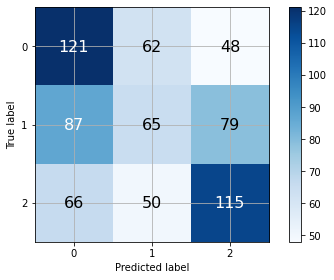

In [76]:
rf_tuned_clf = RandomForestClassifier(
    n_estimators=rf_best_params['n_estimators'],
    max_depth=rf_best_params['max_depth'],
    min_samples_split=rf_best_params['min_samples_split'],
    min_samples_leaf=rf_best_params['min_samples_leaf'],
    max_features=rf_best_params['max_features'],
    bootstrap=rf_best_params['n_estimators'],
    random_state=rand_state
)

# Cross Validation Scores
get_mean_cvs(rf_tuned_clf, X_train, y_train)

rf_tuned_clf.fit(X_train, y_train)
print(f'Accuracy: {rf_tuned_clf.score(X_test, y_test)}')

y_test_pred_rf_tuned = rf_tuned_clf.predict(X_test)
evaluate_model(y_true=y_test, y_pred=y_test_pred_rf_tuned)

### Model with Feature Selection A:0.434 

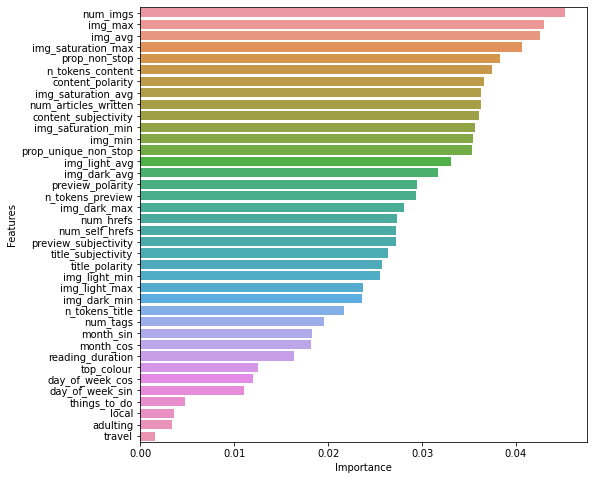

In [77]:
rf_feature_impt = plot_feature_impt(model=rf_tuned_clf, X=X_test)

Number of Features Selected: 2
Cross Validation Score: 0.351247 (0.028211)
Number of Features Selected: 6
Cross Validation Score: 0.419789 (0.030908)
Number of Features Selected: 10
Cross Validation Score: 0.432547 (0.028993)
Number of Features Selected: 14
Cross Validation Score: 0.433145 (0.031481)
Number of Features Selected: 18
Cross Validation Score: 0.433744 (0.033271)
Number of Features Selected: 22
Cross Validation Score: 0.431226 (0.026006)
Number of Features Selected: 26
Cross Validation Score: 0.432784 (0.026299)
Number of Features Selected: 30
Cross Validation Score: 0.433986 (0.032926)
Number of Features Selected: 34
Cross Validation Score: 0.436997 (0.030683)
Number of Features Selected: 38
Cross Validation Score: 0.438803 (0.032161)


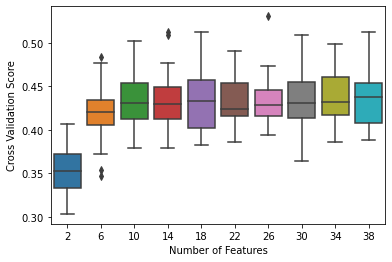

In [78]:
results, features = list(), list()

for i in range(2, X_train.shape[1] + 1, 4):
    print(f'Number of Features Selected: {i}')
    rf_temp_clf = RandomForestClassifier(random_state=rand_state)

    # Cross Validation Scores
    scores = get_mean_cvs(rf_temp_clf,
                          X_train[rf_feature_impt.Features[:i]],
                          y_train)

    results.append(scores)
    features.append(i)

# Plot Boxplot of Performance Across Number of Features Selected
g = sns.boxplot(data=results)
g.set(xlabel='Number of Features', ylabel='Cross Validation Score')
plt.xticks(ticks=range(len(features)), labels=features)
plt.show()

best_index = np.argmax(a=[x.mean() for x in results])
top_feat_rf = rf_feature_impt.Features[:features[best_index]]

In [79]:
# All features yield the best result
top_feat_rf.tolist()

['num_imgs',
 'img_max',
 'img_avg',
 'img_saturation_max',
 'prop_non_stop',
 'n_tokens_content',
 'content_polarity',
 'img_saturation_avg',
 'num_articles_written',
 'content_subjectivity',
 'img_saturation_min',
 'img_min',
 'prop_unique_non_stop',
 'img_light_avg',
 'img_dark_avg',
 'preview_polarity',
 'n_tokens_preview',
 'img_dark_max',
 'num_hrefs',
 'num_self_hrefs',
 'preview_subjectivity',
 'title_subjectivity',
 'title_polarity',
 'img_light_min',
 'img_light_max',
 'img_dark_min',
 'n_tokens_title',
 'num_tags',
 'month_sin',
 'month_cos',
 'reading_duration',
 'top_colour',
 'day_of_week_cos',
 'day_of_week_sin',
 'things_to_do',
 'local',
 'adulting',
 'travel']

In [80]:
grid = dict(n_estimators=[10, 100, 1000],
            max_depth=[int(x) for x in np.linspace(start=10, stop=110, num=11)] + [None],
            min_samples_split=[2, 5, 10],
            min_samples_leaf=[1, 2, 4],
            max_features = ['auto', 'sqrt'],
            bootstrap = [True, False])

rf_feat_params = get_best_params(model=RandomForestClassifier(random_state=rand_state),
                                 grid=grid,
                                 X=X_train,
                                 y=y_train,
                                 is_iterate_all=False)

Best: 0.440127 using {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 100, 'bootstrap': False}
0.435066 (0.010566) with: {'n_estimators': 1000, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'auto', 'max_depth': 60, 'bootstrap': True}
0.440127 (0.016331) with: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 100, 'bootstrap': False}
0.410169 (0.013957) with: {'n_estimators': 10, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 40, 'bootstrap': False}
0.440127 (0.016331) with: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': 110, 'bootstrap': False}
0.439034 (0.009891) with: {'n_estimators': 1000, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': 50, 'bootstrap': True}
0.436154 (0.010563) with: {'n_estimators': 1000, 'min_samples_spli

Cross Validation Score: 0.434835 (0.026708)
Accuracy: 0.43434343434343436
              precision    recall  f1-score   support

           0       0.44      0.52      0.48       231
           1       0.37      0.28      0.32       231
           2       0.48      0.50      0.49       231

    accuracy                           0.43       693
   macro avg       0.43      0.43      0.43       693
weighted avg       0.43      0.43      0.43       693



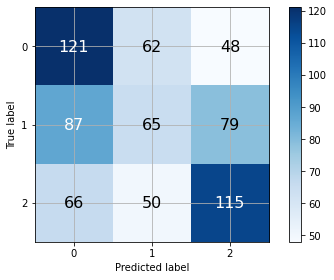

In [81]:
rf_feat_clf = RandomForestClassifier(
    n_estimators=rf_best_params['n_estimators'],
    max_depth=rf_best_params['max_depth'],
    min_samples_split=rf_best_params['min_samples_split'],
    min_samples_leaf=rf_best_params['min_samples_leaf'],
    max_features=rf_best_params['max_features'],
    bootstrap=rf_best_params['n_estimators'],
    random_state=rand_state
)

# Cross Validation Scores
get_mean_cvs(rf_feat_clf, X_train, y_train)

rf_feat_clf.fit(X_train, y_train)
print(f'Accuracy: {rf_feat_clf.score(X_test, y_test)}')

y_test_pred_rf_feat = rf_feat_clf.predict(X_test)
evaluate_model(y_true=y_test, y_pred=y_test_pred_rf_feat)

## Stacking Classifier

### Model with DecisionTree A:0.413 F1:0.40

Cross Validation Score: 0.388896 (0.027428)
Accuracy: 0.4126984126984127
              precision    recall  f1-score   support

           0       0.41      0.49      0.45       231
           1       0.39      0.25      0.30       231
           2       0.42      0.50      0.46       231

    accuracy                           0.41       693
   macro avg       0.41      0.41      0.40       693
weighted avg       0.41      0.41      0.40       693



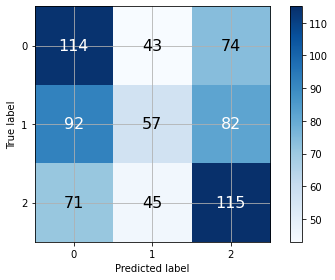

In [82]:
tuned_learners = [
    ('svc', SVC(
        C=0.1,
        kernel='rbf',
        gamma='scale',
        random_state=rand_state)),
    ('dc', DecisionTreeClassifier(
        max_depth=70,
        min_samples_split=2,
        min_samples_leaf=1,
        max_features='auto',
        random_state=rand_state)),
    ('knn', KNeighborsClassifier(
        metric='manhattan',
        n_neighbors=9,
        weights='uniform'))
]

# Initialize Stacking Classifier with the Meta Learner
s_tuned_clf = StackingClassifier(estimators=tuned_learners,
                                final_estimator=LogisticRegression(random_state=rand_state),
                                cv=5,
                                n_jobs=-1)

# Cross Validation Scores
get_mean_cvs(s_tuned_clf, X_train, y_train)

s_tuned_clf.fit(X_train, y_train)
print(f'Accuracy: {s_tuned_clf.score(X_test, y_test)}')

y_test_pred_s_tuned = s_tuned_clf.predict(X_test)
evaluate_model(y_true=y_test, y_pred=y_test_pred_s_tuned)

### Model with RandomForest A:0.426 F1:0.41

Cross Validation Score: 0.438803 (0.031185)
Accuracy: 0.43001443001443
              precision    recall  f1-score   support

           0       0.44      0.56      0.49       231
           1       0.38      0.17      0.24       231
           2       0.44      0.55      0.49       231

    accuracy                           0.43       693
   macro avg       0.42      0.43      0.41       693
weighted avg       0.42      0.43      0.41       693



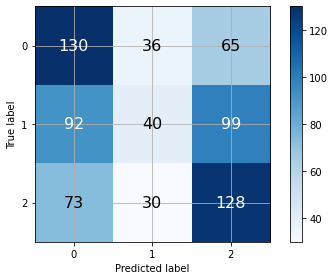

In [83]:
tuned_learners = [
    ('svc', SVC(
        C=0.1,
        kernel='rbf',
        gamma='scale',
        random_state=rand_state)),
    ('rf', RandomForestClassifier(
        n_estimators=100,
        min_samples_split=2,
        min_samples_leaf=2,
        max_features='auto',
        max_depth=100,
        bootstrap=False)),
    ('knn', KNeighborsClassifier(
        metric='manhattan',
        n_neighbors=9,
        weights='uniform'))
]

# Initialize Stacking Classifier with the Meta Learner
s_tuned_clf = StackingClassifier(estimators=tuned_learners,
                                final_estimator=LogisticRegression(random_state=rand_state),
                                cv=5,
                                n_jobs=-1)

# Cross Validation Scores
get_mean_cvs(s_tuned_clf, X_train, y_train)

s_tuned_clf.fit(X_train, y_train)
print(f'Accuracy: {s_tuned_clf.score(X_test, y_test)}')

y_test_pred_s_tuned = s_tuned_clf.predict(X_test)
evaluate_model(y_true=y_test, y_pred=y_test_pred_s_tuned)

## Boosting - AdaBoost

### Base Model A:0.433 F1:0.42

Cross Validation Score: 0.443620 (0.032315)
Accuracy: 0.4329004329004329
              precision    recall  f1-score   support

           0       0.44      0.55      0.49       231
           1       0.35      0.26      0.29       231
           2       0.49      0.50      0.49       231

    accuracy                           0.43       693
   macro avg       0.42      0.43      0.42       693
weighted avg       0.42      0.43      0.42       693



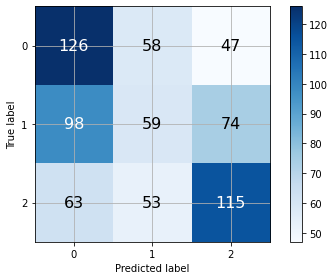

In [84]:
ab_base_clf = AdaBoostClassifier(random_state=rand_state)

# Cross Validation Scores
get_mean_cvs(ab_base_clf, X_train, y_train)

ab_base_clf.fit(X_train, y_train)
print(f'Accuracy: {ab_base_clf.score(X_test, y_test)}')

y_test_pred_ab_base = ab_base_clf.predict(X_test)
evaluate_model(y_true=y_test, y_pred=y_test_pred_ab_base)

### Model with Best Params A:0.449 F1:0.43

In [85]:
grid = {
    'base_estimator': [DecisionTreeClassifier(max_depth=1,
                                              random_state=rand_state),
                       DecisionTreeClassifier(random_state=rand_state), 
                       DecisionTreeClassifier(min_samples_split=2,
                                              min_samples_leaf=1,
                                              max_features='auto',
                                              max_depth=70,
                                              random_state=rand_state)],
    'n_estimators': np.arange(1, 200, 1),
    'algorithm': ['SAMME.R', 'SAMME'],
    'learning_rate': np.arange(0.0, 1.01, 0.01)
    }

ab_best_params = get_best_params(model=AdaBoostClassifier(random_state=rand_state),
                                 grid=grid,
                                 X=X_train,
                                 y=y_train,
                                 is_iterate_all=False)

Best: 0.443719 using {'n_estimators': 186, 'learning_rate': 0.52, 'base_estimator': DecisionTreeClassifier(max_depth=1, random_state=18), 'algorithm': 'SAMME'}
0.433620 (0.007067) with: {'n_estimators': 20, 'learning_rate': 0.02, 'base_estimator': DecisionTreeClassifier(max_depth=1, random_state=18), 'algorithm': 'SAMME'}
0.379868 (0.011711) with: {'n_estimators': 158, 'learning_rate': 0.7000000000000001, 'base_estimator': DecisionTreeClassifier(random_state=18), 'algorithm': 'SAMME'}
0.379868 (0.011711) with: {'n_estimators': 115, 'learning_rate': 0.54, 'base_estimator': DecisionTreeClassifier(random_state=18), 'algorithm': 'SAMME'}
0.379868 (0.011711) with: {'n_estimators': 33, 'learning_rate': 0.78, 'base_estimator': DecisionTreeClassifier(random_state=18), 'algorithm': 'SAMME.R'}
0.442998 (0.011533) with: {'n_estimators': 135, 'learning_rate': 0.08, 'base_estimator': DecisionTreeClassifier(max_depth=1, random_state=18), 'algorithm': 'SAMME.R'}
0.358229 (0.013958) with: {'n_estimato

Cross Validation Score: 0.439044 (0.028157)
Accuracy: 0.44877344877344877
              precision    recall  f1-score   support

           0       0.45      0.58      0.51       231
           1       0.38      0.23      0.29       231
           2       0.48      0.53      0.50       231

    accuracy                           0.45       693
   macro avg       0.44      0.45      0.43       693
weighted avg       0.44      0.45      0.43       693



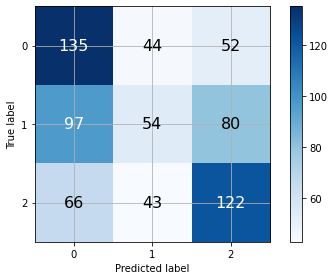

In [86]:
ab_tuned_clf = AdaBoostClassifier(
    base_estimator=ab_best_params['base_estimator'],
    n_estimators=ab_best_params['n_estimators'],
    algorithm=ab_best_params['algorithm'],
    learning_rate=ab_best_params['learning_rate'],
    random_state=rand_state
)

# Cross Validation Scores
get_mean_cvs(ab_tuned_clf, X_train, y_train)

ab_tuned_clf.fit(X_train, y_train)
print(f'Accuracy: {ab_tuned_clf.score(X_test, y_test)}')

y_test_pred_ab_tuned = ab_tuned_clf.predict(X_test)
evaluate_model(y_true=y_test, y_pred=y_test_pred_ab_tuned)

### Model with Feature Selection A: 0.444 F1:0.43

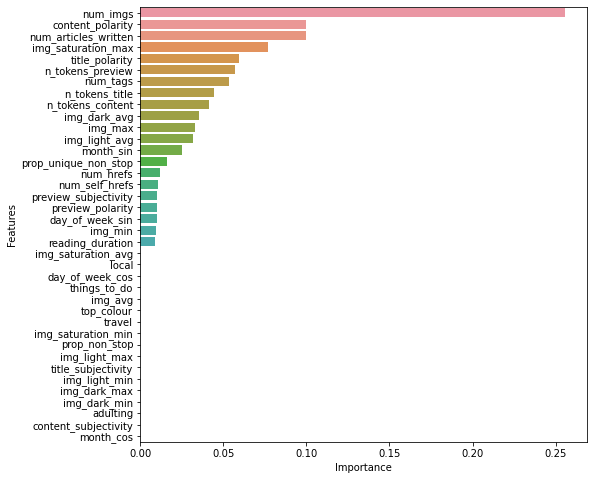

In [87]:
ab_feature_impt = plot_feature_impt(model=ab_tuned_clf, X=X_test)

Number of Features Selected: 2
Cross Validation Score: 0.435792 (0.030671)
Number of Features Selected: 6
Cross Validation Score: 0.440006 (0.030845)
Number of Features Selected: 10
Cross Validation Score: 0.439645 (0.030408)
Number of Features Selected: 14
Cross Validation Score: 0.435073 (0.029012)
Number of Features Selected: 18
Cross Validation Score: 0.444454 (0.030685)
Number of Features Selected: 22
Cross Validation Score: 0.443617 (0.034759)
Number of Features Selected: 26
Cross Validation Score: 0.439650 (0.031605)
Number of Features Selected: 30
Cross Validation Score: 0.436408 (0.029894)
Number of Features Selected: 34
Cross Validation Score: 0.437719 (0.033221)
Number of Features Selected: 38
Cross Validation Score: 0.443620 (0.032315)


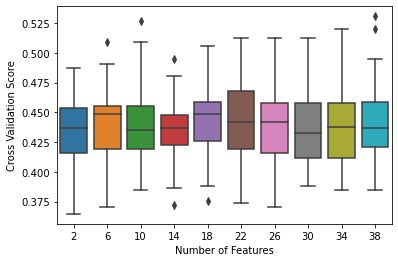

In [88]:
results, features = list(), list()

for i in range(2, X_train.shape[1] + 1, 4):
    print(f'Number of Features Selected: {i}')
    ab_temp_clf = AdaBoostClassifier(random_state=rand_state)

    # Cross Validation Scores
    scores = get_mean_cvs(ab_temp_clf,
                          X_train[ab_feature_impt.Features[:i]],
                          y_train)

    results.append(scores)
    features.append(i)

# Plot Boxplot of Performance Across Number of Features Selected
g = sns.boxplot(data=results)
g.set(xlabel='Number of Features', ylabel='Cross Validation Score')
plt.xticks(ticks=range(len(features)), labels=features)
plt.show()

best_index = np.argmax(a=[x.mean() for x in results])
top_feat_ab = ab_feature_impt.Features[:features[best_index]]

In [89]:
top_feat_ab.tolist()

['num_imgs',
 'content_polarity',
 'num_articles_written',
 'img_saturation_max',
 'title_polarity',
 'n_tokens_preview',
 'num_tags',
 'n_tokens_title',
 'n_tokens_content',
 'img_dark_avg',
 'img_max',
 'img_light_avg',
 'month_sin',
 'prop_unique_non_stop',
 'num_hrefs',
 'num_self_hrefs',
 'preview_subjectivity',
 'preview_polarity']

In [90]:
grid = {
    'base_estimator': [DecisionTreeClassifier(max_depth=1,
                                              random_state=rand_state),
                       DecisionTreeClassifier(random_state=rand_state), 
                       DecisionTreeClassifier(min_samples_split=2,
                                              min_samples_leaf=1,
                                              max_features='auto',
                                              max_depth=70,
                                              random_state=rand_state)],
    'n_estimators': np.arange(1, 200, 1),
    'algorithm': ['SAMME.R', 'SAMME'],
    'learning_rate': np.arange(0.0, 1.01, 0.01)
    }

ab_best_params = get_best_params(model=AdaBoostClassifier(random_state=rand_state),
                                 grid=grid,
                                 X=X_train[top_feat_ab],
                                 y=y_train,
                                 is_iterate_all=False)

Best: 0.448408 using {'n_estimators': 186, 'learning_rate': 0.52, 'base_estimator': DecisionTreeClassifier(max_depth=1, random_state=18), 'algorithm': 'SAMME'}
0.433620 (0.007067) with: {'n_estimators': 20, 'learning_rate': 0.02, 'base_estimator': DecisionTreeClassifier(max_depth=1, random_state=18), 'algorithm': 'SAMME'}
0.372290 (0.008609) with: {'n_estimators': 158, 'learning_rate': 0.7000000000000001, 'base_estimator': DecisionTreeClassifier(random_state=18), 'algorithm': 'SAMME'}
0.372290 (0.008609) with: {'n_estimators': 115, 'learning_rate': 0.54, 'base_estimator': DecisionTreeClassifier(random_state=18), 'algorithm': 'SAMME'}
0.372290 (0.008609) with: {'n_estimators': 33, 'learning_rate': 0.78, 'base_estimator': DecisionTreeClassifier(random_state=18), 'algorithm': 'SAMME.R'}
0.446606 (0.011441) with: {'n_estimators': 135, 'learning_rate': 0.08, 'base_estimator': DecisionTreeClassifier(max_depth=1, random_state=18), 'algorithm': 'SAMME.R'}
0.376612 (0.029731) with: {'n_estimato

Cross Validation Score: 0.443616 (0.030020)
Accuracy: 0.4444444444444444
              precision    recall  f1-score   support

           0       0.46      0.58      0.51       231
           1       0.35      0.24      0.29       231
           2       0.49      0.52      0.50       231

    accuracy                           0.44       693
   macro avg       0.43      0.44      0.43       693
weighted avg       0.43      0.44      0.43       693



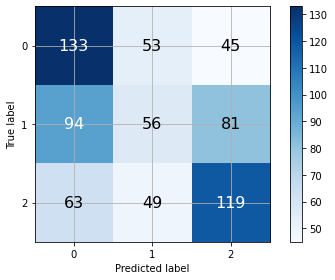

In [91]:
ab_feat_clf = AdaBoostClassifier(
    base_estimator=ab_best_params['base_estimator'],
    n_estimators=ab_best_params['n_estimators'],
    algorithm=ab_best_params['algorithm'],
    learning_rate=ab_best_params['learning_rate'],
    random_state=rand_state
)

# Cross Validation Scores
get_mean_cvs(ab_feat_clf, X_train[top_feat_ab], y_train)

ab_feat_clf.fit(X_train[top_feat_ab], y_train)
print(f'Accuracy: {ab_feat_clf.score(X_test[top_feat_ab], y_test)}')

y_test_pred_ab_feat = ab_feat_clf.predict(X_test[top_feat_ab])
evaluate_model(y_true=y_test, y_pred=y_test_pred_ab_feat)

## Boosting - Gradient Boosting

### Base Model A:0.434 F1:0.43

Cross Validation Score: 0.436997 (0.033604)
Accuracy: 0.43434343434343436
              precision    recall  f1-score   support

           0       0.45      0.53      0.49       231
           1       0.35      0.29      0.32       231
           2       0.48      0.48      0.48       231

    accuracy                           0.43       693
   macro avg       0.43      0.43      0.43       693
weighted avg       0.43      0.43      0.43       693



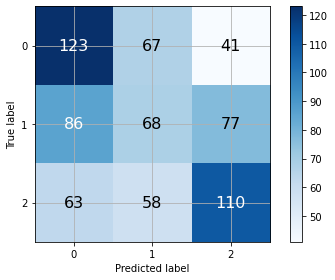

In [92]:
gb_base_clf = GradientBoostingClassifier(random_state=rand_state)

# Cross Validation Scores
get_mean_cvs(gb_base_clf, X_train, y_train)

gb_base_clf.fit(X_train, y_train)
print(f'Accuracy: {gb_base_clf.score(X_test, y_test)}')

y_test_pred_gb_base = gb_base_clf.predict(X_test)
evaluate_model(y_true=y_test, y_pred=y_test_pred_gb_base)

### Model with Best Params A:0.442 F1:0.43

In [93]:
grid = {
    'n_estimators': np.arange(1, 250, 1),
    'criterion': ['friedman_mse', 'squared_error', 'mse'],
    'loss': ['log_loss', 'deviance', 'exponential'],
    'learning_rate': np.arange(0.0, 2, 0.01),
    'max_depth': [int(x) for x in np.linspace(start=1, stop=50, num = 1)] + [None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt'],
}

gb_best_params = get_best_params(
    model=GradientBoostingClassifier(random_state=rand_state),
    grid=grid,
    X=X_train,
    y=y_train,
    is_iterate_all=False
)

Best: 0.438321 using {'n_estimators': 43, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 1, 'loss': 'log_loss', 'learning_rate': 0.47000000000000003, 'criterion': 'squared_error'}
0.416298 (0.009937) with: {'n_estimators': 157, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': None, 'loss': 'log_loss', 'learning_rate': 1.09, 'criterion': 'squared_error'}
0.419184 (0.014341) with: {'n_estimators': 70, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': None, 'loss': 'log_loss', 'learning_rate': 0.86, 'criterion': 'squared_error'}
0.438321 (0.016738) with: {'n_estimators': 43, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 1, 'loss': 'log_loss', 'learning_rate': 0.47000000000000003, 'criterion': 'squared_error'}
0.417742 (0.012792) with: {'n_estimators': 242, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': None, 'l

Cross Validation Score: 0.443740 (0.029177)
Accuracy: 0.44155844155844154
              precision    recall  f1-score   support

           0       0.45      0.55      0.50       231
           1       0.35      0.27      0.30       231
           2       0.50      0.51      0.50       231

    accuracy                           0.44       693
   macro avg       0.43      0.44      0.43       693
weighted avg       0.43      0.44      0.43       693



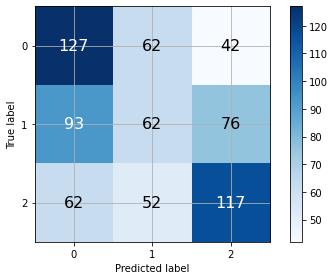

In [94]:
gb_tuned_clf = GradientBoostingClassifier(
    n_estimators=gb_best_params['n_estimators'],
    criterion=gb_best_params['criterion'],
    loss=gb_best_params['loss'],
    learning_rate=gb_best_params['learning_rate'],
    max_depth=gb_best_params['max_depth'],
    min_samples_split=gb_best_params['min_samples_split'],
    min_samples_leaf=gb_best_params['min_samples_leaf'],
    max_features=gb_best_params['max_features'],
    random_state=rand_state
)

# Cross Validation Scores
get_mean_cvs(gb_tuned_clf, X_train, y_train)

gb_tuned_clf.fit(X_train, y_train)
print(f'Accuracy: {gb_tuned_clf.score(X_test, y_test)}')

y_test_pred_gb_tuned = gb_tuned_clf.predict(X_test)
evaluate_model(y_true=y_test, y_pred=y_test_pred_gb_tuned)

### Model with Feature Selection A:0.440 F1:0.43

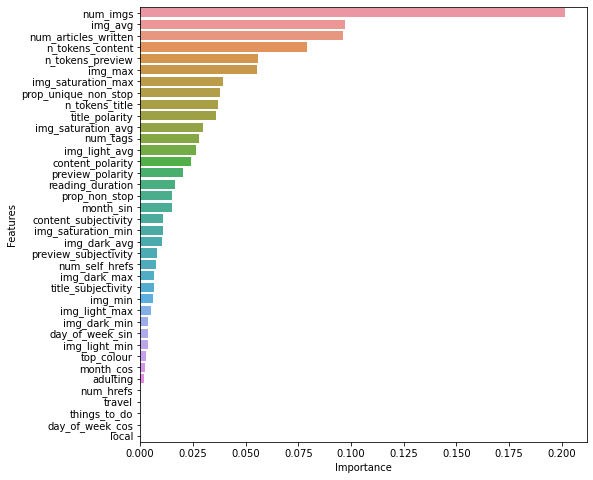

In [95]:
gb_feature_impt = plot_feature_impt(model=gb_tuned_clf, X=X_test)

Number of Features Selected: 2
Cross Validation Score: 0.423639 (0.026701)
Number of Features Selected: 6
Cross Validation Score: 0.431229 (0.027648)
Number of Features Selected: 10
Cross Validation Score: 0.437230 (0.028983)
Number of Features Selected: 14
Cross Validation Score: 0.440489 (0.030444)
Number of Features Selected: 18
Cross Validation Score: 0.440967 (0.031214)
Number of Features Selected: 22
Cross Validation Score: 0.437962 (0.028622)
Number of Features Selected: 26
Cross Validation Score: 0.438919 (0.029921)
Number of Features Selected: 30
Cross Validation Score: 0.438562 (0.033663)
Number of Features Selected: 34
Cross Validation Score: 0.437590 (0.030309)
Number of Features Selected: 38
Cross Validation Score: 0.437478 (0.033914)


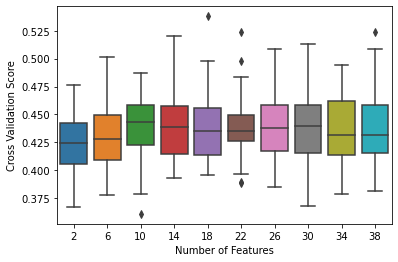

In [96]:
results, features = list(), list()

for i in range(2, X_train.shape[1] + 1, 4):
    print(f'Number of Features Selected: {i}')
    gb_temp_clf = GradientBoostingClassifier(random_state=rand_state)

    # Cross Validation Scores
    scores = get_mean_cvs(gb_temp_clf,
                          X_train[gb_feature_impt.Features[:i]],
                          y_train)

    results.append(scores)
    features.append(i)

# Plot Boxplot of Performance Across Number of Features Selected
g = sns.boxplot(data=results)
g.set(xlabel='Number of Features', ylabel='Cross Validation Score')
plt.xticks(ticks=range(len(features)), labels=features)
plt.show()

best_index = np.argmax(a=[x.mean() for x in results])
top_feat_gb = gb_feature_impt.Features[:features[best_index]]

In [97]:
top_feat_gb

17                num_imgs
31                 img_avg
0     num_articles_written
11        n_tokens_content
8         n_tokens_preview
32                 img_max
29      img_saturation_max
15    prop_unique_non_stop
5           n_tokens_title
6           title_polarity
28      img_saturation_avg
20                num_tags
25           img_light_avg
12        content_polarity
9         preview_polarity
16        reading_duration
14           prop_non_stop
36               month_sin
Name: Features, dtype: object

In [98]:
grid = {
    'n_estimators': np.arange(1, 250, 1),
    'criterion': ['friedman_mse', 'squared_error', 'mse'],
    'loss': ['log_loss', 'deviance', 'exponential'],
    'learning_rate': np.arange(0.0, 2, 0.01),
    'max_depth': [int(x) for x in np.linspace(start=1, stop=50, num = 1)] + [None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt'],
}

gb_feat_params = get_best_params(
    model=GradientBoostingClassifier(random_state=rand_state),
    grid=grid,
    X=X_train[top_feat_gb],
    y=y_train,
    is_iterate_all=False
)

Best: 0.448419 using {'n_estimators': 43, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 1, 'loss': 'log_loss', 'learning_rate': 0.47000000000000003, 'criterion': 'squared_error'}
0.420274 (0.016086) with: {'n_estimators': 157, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_features': 'sqrt', 'max_depth': None, 'loss': 'log_loss', 'learning_rate': 1.09, 'criterion': 'squared_error'}
0.405121 (0.026665) with: {'n_estimators': 70, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'auto', 'max_depth': None, 'loss': 'log_loss', 'learning_rate': 0.86, 'criterion': 'squared_error'}
0.448419 (0.021599) with: {'n_estimators': 43, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 1, 'loss': 'log_loss', 'learning_rate': 0.47000000000000003, 'criterion': 'squared_error'}
0.415218 (0.012601) with: {'n_estimators': 242, 'min_samples_split': 2, 'min_samples_leaf': 4, 'max_features': 'auto', 'max_depth': None, 'l

Cross Validation Score: 0.451914 (0.031898)
Accuracy: 0.4401154401154401
              precision    recall  f1-score   support

           0       0.45      0.58      0.50       231
           1       0.35      0.24      0.29       231
           2       0.49      0.50      0.49       231

    accuracy                           0.44       693
   macro avg       0.43      0.44      0.43       693
weighted avg       0.43      0.44      0.43       693



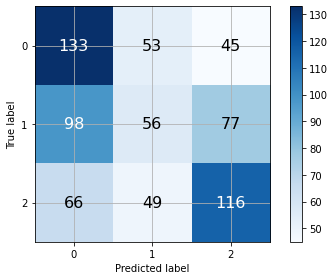

In [99]:
gb_feat_clf = GradientBoostingClassifier(
    n_estimators=gb_best_params['n_estimators'],
    criterion=gb_best_params['criterion'],
    loss=gb_best_params['loss'],
    learning_rate=gb_best_params['learning_rate'],
    max_depth=gb_best_params['max_depth'],
    min_samples_split=gb_best_params['min_samples_split'],
    min_samples_leaf=gb_best_params['min_samples_leaf'],
    max_features=gb_best_params['max_features'],
    random_state=rand_state
)

# Cross Validation Scores
get_mean_cvs(gb_feat_clf, X_train[top_feat_gb], y_train)

gb_feat_clf.fit(X_train[top_feat_gb], y_train)
print(f'Accuracy: {gb_feat_clf.score(X_test[top_feat_gb], y_test)}')

y_test_pred_gb_feat = gb_feat_clf.predict(X_test[top_feat_gb])
evaluate_model(y_true=y_test, y_pred=y_test_pred_gb_feat)

## Voting Classifier A:0.456 F1:0.44

Cross Validation Score: 0.443617 (0.025912)
Accuracy: 0.455988455988456
              precision    recall  f1-score   support

           0       0.45      0.63      0.53       231
           1       0.39      0.23      0.28       231
           2       0.50      0.52      0.51       231

    accuracy                           0.46       693
   macro avg       0.45      0.46      0.44       693
weighted avg       0.45      0.46      0.44       693



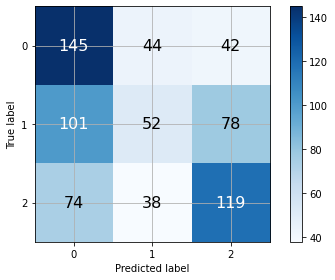

In [100]:
voting_clf = VotingClassifier(
    estimators=[('lr', lr_tuned_model),
                ('svc', svm_tuned_clf),
                ('ab', ab_tuned_clf)],
    voting='hard',
    n_jobs=-1
)

# Cross Validation Scores
get_mean_cvs(voting_clf, X_train_scaled, y_train)

voting_clf.fit(X_train_scaled, y_train)
print(f'Accuracy: {voting_clf.score(X_test_scaled, y_test)}')

y_test_pred_voting = voting_clf.predict(X_test_scaled)
evaluate_model(y_true=y_test, y_pred=y_test_pred_voting)